# PERCEPTRÓN PARA CLASIFICACIÓN - (UNA SOLA NEURONA) - CON FUNC ACTIVACIÓN SIGMOIDAL

## Edison David González Blandón - Juan Esteban Velásquez

### Obteniendo y normalizando datos

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
datos_xls = pd.ExcelFile('DatosPunto2.xlsx') #Obteniendo el archivo
sheet_names = datos_xls.sheet_names #Obteniendo un arreglo con los nombres de las hojas del libro de excel
hoja = datos_xls.parse(sheet_names[0]) #Nuestra hoja de trabajo es la primera pestaña
#print("Imprimiendo el contenido de la hoja de excel: ")
#print(hoja)
columnas = [] #Una lista vacia de columnas 
columnas_norm = [] #Una lista vacia de las columnas normalizadas
for i in range(1,17):      
    columnas.append(hoja.iloc[:,i]) #Se agrega a la lista el elemento = a un arreglo o columna 
    columnas_norm.append((columnas[i-1]-np.min(columnas[i-1],axis=0))/(np.max(columnas[i-1],axis=0)-np.min(columnas[i-1],axis=0))) ## Estandarizando con Min-Max (  En latex lo siguiente:   $$X_{norm} = \frac{X-\min(X)}{\max(X)-\min(X)}$$  )   axis=0 -> filas  y  axis=1 -> columnas
#print("Imprimiendo la lista columnas: ", columnas)
#print("Verificando si es una lista o que tipo es la variable columnas: ", type(columnas))
#print("Dimensiones de la lista columnas: ", np.shape(columnas))
#print("Obteniendo columnas[0]: ", columnas[0])
#print("Obteniendo columnas[1]: ", columnas[1])
#print("Obteniendo columnas[15]: ", columnas[15])
#print("Dimensiones de la lista de columnas normalizadas: ", np.shape(columnas_norm))
#print("Columnas normalizadas: ", columnas_norm)

### Obtenemos la matriz de salida (Valores: Clase1: -1, Clase2: 1 ; [-1,1]) 

In [19]:
#Etiquetados: 1 si la letra esta dentro de mi apellido, -1 caso contrario
vect_letras=['G','O','N','Z','A','L','E','Z','V','S','Q','U'] #Vector para definir cuales son los de la clase 1
lista_etiqueta=[]#Se crea una lista, en la cual se almacenará el etiquetado de -1 y 1 para las clases 1 y 2
matriz_datos=np.array(hoja)
#print(np.shape(matriz_datos))
for i in range (len(matriz_datos)): #For que va desde i hasta el tamaño de la matriz de datos
    for j in range (len(vect_letras)): #Recorriendo el vector de letras
        if(matriz_datos[i,0]==vect_letras[j]): #Comparando si la fila de los datos en la columna 0 coincide con una letra del vector donde estan las letras de apellidos
            flag_clase1=True #Pertenece a la clase 1
            break #Dejar de recorrer el vector letras del apellido, si encuentra la letra
        else:
            flag_clase1=False #Sino es una etiqeta cualquiera
    if(flag_clase1): #Si se levanto la bandera que es entonces las etiquetas se colocan en 1
        lista_etiqueta.append(1)
    else:
        lista_etiqueta.append(-1) #Sino en -1
#print(matriz_datos[0])
#print(matriz_datos[0:20,0],lista_etiqueta[0:20])
#print(type(lista_etiqueta), len(lista_etiqueta))

### Dividir la matriz de datos de entrada para entrenamiento, validación y prueba

In [20]:
Numero_Filas_Datos = len(columnas_norm[0]) #Obteniendo la cantidad de elementos en una lista, es decir la cantidad de filas
#print("Numero de filas de datos: ", Numero_Filas_Datos) 
#Se realiza la división para hacer bootstraping
N_datos_entrenamiento = int(Numero_Filas_Datos*0.7) #70% para entrenamiento 
N_datos_validacion = int(Numero_Filas_Datos*0.15) #15% para validación
N_datos_prueba = Numero_Filas_Datos - N_datos_validacion - N_datos_entrenamiento #15% para prueba
#print("Número de datos que se tomarán para entrenamiento: ", N_datos_entrenamiento)
#print("Número de datos para la validación: ", N_datos_validacion)
#print("Número de datos para prueba: ", N_datos_prueba)

matrix_normalizado = np.array(columnas_norm).T #Ya quedo un vector de 20000 filas y 16 columnas
vector_etiquetas=np.array(lista_etiqueta) #Pasarlo a vector
#print("Dimension del vector de etiqueta", np.shape(vector_etiquetas)) #Dimensiones del vector etiqueta
#print("Viendo las primeras 20 etiquetas: ", vector_etiquetas[0:20])

matrix_entrenamiento = matrix_normalizado[0:N_datos_entrenamiento,:] #Matriz[14000,16]
#print("Dimensión de la matriz de entrenamiento: ", matrix_entrenamiento.shape)
vector_etiquetas_entrenamiento = vector_etiquetas[0:N_datos_entrenamiento] #Matriz[14000,1]
#print("Dimensión vector de entrenamiento: ", vector_etiquetas_entrenamiento.shape)
matrix_validacion = matrix_normalizado[N_datos_entrenamiento:(N_datos_entrenamiento+N_datos_validacion),:] #Matriz[3000,16]
#print("Dimensión de la matriz de validación: ", matrix_validacion.shape)
vector_etiquetas_validacion = vector_etiquetas[N_datos_entrenamiento:(N_datos_entrenamiento+N_datos_validacion)] #Matriz[3000,1]
#print("Dimensión vector de validación: ", vector_etiquetas_validacion.shape)
matrix_prueba = matrix_normalizado[N_datos_validacion:(N_datos_validacion+N_datos_prueba),:] #Matriz[3000,16]
#print("Dimensión de la matriz de prueba: ", matrix_prueba.shape)
vector_etiquetas_prueba = vector_etiquetas[N_datos_validacion:(N_datos_validacion+N_datos_prueba)] #Matriz[3000,1]
#print("Dimensión vector de prueba: ", vector_etiquetas_prueba.shape)

### Definiendo funciones necesarias para implementar el algoritmo perceptrón

In [21]:
#Definición de la función sigmoidal
def sigmoid(x):
    return 1/(1+np.exp(-x))


### Implementando algoritmo Perceptron para entrenamiento e Implementando validación según eficiencia

In [22]:
def Perceptron_Train(matrix_entrenamiento, vector_etiquetas_entrenamiento, max_iteraciones = 2000, eficiencia_min = 0.65):
    #Banderas y variables para tener el control del entrenamiento 
    flag_culm = True #Bandera que indica cuando culminar las iteracciones
    contador_iterac = 0
    result_valid = False #Resultado de la validación, false si no valida y true si valida
    vector_pesos = np.random.rand(matrix_entrenamiento.shape[1] + 1,) #Obteniendo un vector de numeros aleatorio entre 0 y 1, segun el tamaño de columnas en la matrix de entrenamiento (Shape devuelve las dimensiones de un arreglo) donde shape[0]=filas y shape[1]=columnas 
    contador_error_entrenamiento = 0;
    ultima_eficiencia = 0
    mejor_vector_pesos_validados = vector_pesos
    
    while(flag_culm):
        contador_iterac = contador_iterac + 1;
        #Escoja (xi,yi) al azar
        dato_escogido = np.random.randint(0,N_datos_entrenamiento) #Escogiendo un numero para indicar que fila coger
        g  = np.dot(vector_pesos.T,np.insert(matrix_entrenamiento[dato_escogido,:],0,1)) # y = w.xT donde Y = matriz de salida, wT = Matriz de pesos
        yp = sigmoid(g)-0.5 #Pasando por la funcion de activación que se le baja su offset de 0.5 
        #print(np.shape(yp)) -> Es un escalar
        #print(np.shape(g)) -> Es un escalar
        result_comparacion = yp*vector_etiquetas_entrenamiento[dato_escogido] #result_comparacion = (wTXi)Yi
        if(result_comparacion <= 0):
            # (yp) (etiqueta=y) resultado
            #   +        +         +
            #   +        -         -
            #   -        +         -
            #   -        -         +
            vector_pesos = vector_pesos + np.dot((np.insert(matrix_entrenamiento[dato_escogido,:],0,1).T),vector_etiquetas_entrenamiento[dato_escogido])
            contador_error_entrenamiento += 1; 
        ultima_eficiencia, result_valid, mejor_vector_pesos_validados = func_valid(vector_pesos, matrix_validacion, vector_etiquetas_validacion, eficiencia_min, ultima_eficiencia, mejor_vector_pesos_validados)
        if(contador_iterac==max_iteraciones):
            flag_culm = False #Dejar de iterar
            print("culminacion por iteraciones")
        if(result_valid):
            print("culminacion por validacion")
            flag_culm = False #Dejar de iterar
    print("el numero de iteraciones fue: ",contador_iterac)
    #print("contador de errores train: ",contador_errores_train)
    print("El vector de pesos optimo W es:\n")
    for i in range(0,len(mejor_vector_pesos_validados)):
        print("W[",i,"]=", mejor_vector_pesos_validados[i])
    return mejor_vector_pesos_validados
#print(np.shape(np.insert(matrix_entrenamiento[dato_escogido,:],0,1)))
#print(np.shape(vector_etiquetas_entrenamiento))
#print(np.shape(vector_pesos))

def func_valid(vector_pesos, matrix_validacion, vector_etiquetas_validacion, eficiencia_min, ultima_eficiencia, mejor_vector_pesos_validados):
    #nuestro criterio de parada será una eficiencia respecto al numero de datos analizados
    contador_errores_valid = 0
    matrix_validacion_bias = np.insert(matrix_validacion,0,1,axis=1)
    yp_validacion = np.dot(matrix_validacion_bias,vector_pesos.T)
    for i in range(0,len(yp_validacion)):
        g = sigmoid(yp_validacion[i])-0.5
        if g*vector_etiquetas_validacion[i] < 0: #clasificacion erronea
            contador_errores_valid = contador_errores_valid + 1 #para llevar el conteo de los datos clasificados erroneamente
            
    print("contador de errores validacion: ",contador_errores_valid)
    eficiencia = (len(matrix_validacion)-contador_errores_valid)/len(matrix_validacion)
    print("\nla eficiencia total en validacion fue: ", eficiencia)
    if(eficiencia>ultima_eficiencia):
        ultima_eficiencia = eficiencia
        print("Hasta ahora la mejor eficiencia es: ", ultima_eficiencia)
        vector_pesos_validados = vector_pesos
    else:
        vector_pesos_validados = mejor_vector_pesos_validados #Continua siendo el mismo
    if (eficiencia >= eficiencia_min):
        flag_valid = True
    else:
        flag_valid = False
    return ultima_eficiencia, flag_valid, vector_pesos_validados

### Probando entrenamiento y validación

In [23]:
vector_pesos_final = Perceptron_Train(matrix_entrenamiento, vector_etiquetas_entrenamiento, max_iteraciones = 10000, eficiencia_min = 0.8)
#print("el vector de pesos final es: ",vector_pesos_final)

contador de errores validacion:  1674

la eficiencia total en validacion fue:  0.442
Hasta ahora la mejor eficiencia es:  0.442
contador de errores validacion:  1674

la eficiencia total en validacion fue:  0.442
contador de errores validacion:  1303

la eficiencia total en validacion fue:  0.5656666666666667
Hasta ahora la mejor eficiencia es:  0.5656666666666667
contador de errores validacion:  1303

la eficiencia total en validacion fue:  0.5656666666666667
contador de errores validacion:  1674

la eficiencia total en validacion fue:  0.442
contador de errores validacion:  1336

la eficiencia total en validacion fue:  0.5546666666666666
contador de errores validacion:  1674

la eficiencia total en validacion fue:  0.442
contador de errores validacion:  1326

la eficiencia total en validacion fue:  0.558
contador de errores validacion:  1326

la eficiencia total en validacion fue:  0.558
contador de errores validacion:  1326

la eficiencia total en validacion fue:  0.558
contador de 

contador de errores validacion:  1282

la eficiencia total en validacion fue:  0.5726666666666667
contador de errores validacion:  1673

la eficiencia total en validacion fue:  0.44233333333333336
contador de errores validacion:  1673

la eficiencia total en validacion fue:  0.44233333333333336
contador de errores validacion:  1272

la eficiencia total en validacion fue:  0.576
contador de errores validacion:  1272

la eficiencia total en validacion fue:  0.576
contador de errores validacion:  1674

la eficiencia total en validacion fue:  0.442
contador de errores validacion:  1265

la eficiencia total en validacion fue:  0.5783333333333334
contador de errores validacion:  1674

la eficiencia total en validacion fue:  0.442
contador de errores validacion:  1674

la eficiencia total en validacion fue:  0.442
contador de errores validacion:  1274

la eficiencia total en validacion fue:  0.5753333333333334
contador de errores validacion:  1274

la eficiencia total en validacion fue:  0.57

contador de errores validacion:  1324

la eficiencia total en validacion fue:  0.5586666666666666
contador de errores validacion:  1324

la eficiencia total en validacion fue:  0.5586666666666666
contador de errores validacion:  1010

la eficiencia total en validacion fue:  0.6633333333333333
Hasta ahora la mejor eficiencia es:  0.6633333333333333
contador de errores validacion:  1656

la eficiencia total en validacion fue:  0.448
contador de errores validacion:  977

la eficiencia total en validacion fue:  0.6743333333333333
Hasta ahora la mejor eficiencia es:  0.6743333333333333
contador de errores validacion:  977

la eficiencia total en validacion fue:  0.6743333333333333
contador de errores validacion:  977

la eficiencia total en validacion fue:  0.6743333333333333
contador de errores validacion:  1326

la eficiencia total en validacion fue:  0.558
contador de errores validacion:  1137

la eficiencia total en validacion fue:  0.621
contador de errores validacion:  1137

la eficie

contador de errores validacion:  1143

la eficiencia total en validacion fue:  0.619
contador de errores validacion:  1320

la eficiencia total en validacion fue:  0.56
contador de errores validacion:  1320

la eficiencia total en validacion fue:  0.56
contador de errores validacion:  1177

la eficiencia total en validacion fue:  0.6076666666666667
contador de errores validacion:  1539

la eficiencia total en validacion fue:  0.487
contador de errores validacion:  1174

la eficiencia total en validacion fue:  0.6086666666666667
contador de errores validacion:  1174

la eficiencia total en validacion fue:  0.6086666666666667
contador de errores validacion:  1468

la eficiencia total en validacion fue:  0.5106666666666667
contador de errores validacion:  1221

la eficiencia total en validacion fue:  0.593
contador de errores validacion:  1221

la eficiencia total en validacion fue:  0.593
contador de errores validacion:  1508

la eficiencia total en validacion fue:  0.49733333333333335
c

contador de errores validacion:  1164

la eficiencia total en validacion fue:  0.612
contador de errores validacion:  1538

la eficiencia total en validacion fue:  0.48733333333333334
contador de errores validacion:  1197

la eficiencia total en validacion fue:  0.601
contador de errores validacion:  1197

la eficiencia total en validacion fue:  0.601
contador de errores validacion:  1452

la eficiencia total en validacion fue:  0.516
contador de errores validacion:  1452

la eficiencia total en validacion fue:  0.516
contador de errores validacion:  1452

la eficiencia total en validacion fue:  0.516
contador de errores validacion:  1260

la eficiencia total en validacion fue:  0.58
contador de errores validacion:  1260

la eficiencia total en validacion fue:  0.58
contador de errores validacion:  1260

la eficiencia total en validacion fue:  0.58
contador de errores validacion:  1260

la eficiencia total en validacion fue:  0.58
contador de errores validacion:  1260

la eficiencia to

contador de errores validacion:  1456

la eficiencia total en validacion fue:  0.5146666666666667
contador de errores validacion:  1216

la eficiencia total en validacion fue:  0.5946666666666667
contador de errores validacion:  1216

la eficiencia total en validacion fue:  0.5946666666666667
contador de errores validacion:  1216

la eficiencia total en validacion fue:  0.5946666666666667
contador de errores validacion:  1216

la eficiencia total en validacion fue:  0.5946666666666667
contador de errores validacion:  1329

la eficiencia total en validacion fue:  0.557
contador de errores validacion:  1329

la eficiencia total en validacion fue:  0.557
contador de errores validacion:  1245

la eficiencia total en validacion fue:  0.585
contador de errores validacion:  1245

la eficiencia total en validacion fue:  0.585
contador de errores validacion:  1513

la eficiencia total en validacion fue:  0.49566666666666664
contador de errores validacion:  1113

la eficiencia total en validacio

contador de errores validacion:  1050

la eficiencia total en validacion fue:  0.65
contador de errores validacion:  1050

la eficiencia total en validacion fue:  0.65
contador de errores validacion:  1050

la eficiencia total en validacion fue:  0.65
contador de errores validacion:  1050

la eficiencia total en validacion fue:  0.65
contador de errores validacion:  1050

la eficiencia total en validacion fue:  0.65
contador de errores validacion:  1050

la eficiencia total en validacion fue:  0.65
contador de errores validacion:  1298

la eficiencia total en validacion fue:  0.5673333333333334
contador de errores validacion:  1074

la eficiencia total en validacion fue:  0.642
contador de errores validacion:  1074

la eficiencia total en validacion fue:  0.642
contador de errores validacion:  1626

la eficiencia total en validacion fue:  0.458
contador de errores validacion:  1142

la eficiencia total en validacion fue:  0.6193333333333333
contador de errores validacion:  1142

la efi

contador de errores validacion:  927

la eficiencia total en validacion fue:  0.691
contador de errores validacion:  927

la eficiencia total en validacion fue:  0.691
contador de errores validacion:  927

la eficiencia total en validacion fue:  0.691
contador de errores validacion:  1295

la eficiencia total en validacion fue:  0.5683333333333334
contador de errores validacion:  1023

la eficiencia total en validacion fue:  0.659
contador de errores validacion:  1023

la eficiencia total en validacion fue:  0.659
contador de errores validacion:  1529

la eficiencia total en validacion fue:  0.49033333333333334
contador de errores validacion:  1529

la eficiencia total en validacion fue:  0.49033333333333334
contador de errores validacion:  1529

la eficiencia total en validacion fue:  0.49033333333333334
contador de errores validacion:  1076

la eficiencia total en validacion fue:  0.6413333333333333
contador de errores validacion:  1076

la eficiencia total en validacion fue:  0.6413

contador de errores validacion:  1216

la eficiencia total en validacion fue:  0.5946666666666667
contador de errores validacion:  1242

la eficiencia total en validacion fue:  0.586
contador de errores validacion:  1196

la eficiencia total en validacion fue:  0.6013333333333334
contador de errores validacion:  1196

la eficiencia total en validacion fue:  0.6013333333333334
contador de errores validacion:  1196

la eficiencia total en validacion fue:  0.6013333333333334
contador de errores validacion:  1217

la eficiencia total en validacion fue:  0.5943333333333334
contador de errores validacion:  1222

la eficiencia total en validacion fue:  0.5926666666666667
contador de errores validacion:  1222

la eficiencia total en validacion fue:  0.5926666666666667
contador de errores validacion:  1222

la eficiencia total en validacion fue:  0.5926666666666667
contador de errores validacion:  1222

la eficiencia total en validacion fue:  0.5926666666666667
contador de errores validacion:  

contador de errores validacion:  1040

la eficiencia total en validacion fue:  0.6533333333333333
contador de errores validacion:  1040

la eficiencia total en validacion fue:  0.6533333333333333
contador de errores validacion:  1040

la eficiencia total en validacion fue:  0.6533333333333333
contador de errores validacion:  1617

la eficiencia total en validacion fue:  0.461
contador de errores validacion:  1028

la eficiencia total en validacion fue:  0.6573333333333333
contador de errores validacion:  1028

la eficiencia total en validacion fue:  0.6573333333333333
contador de errores validacion:  1028

la eficiencia total en validacion fue:  0.6573333333333333
contador de errores validacion:  1028

la eficiencia total en validacion fue:  0.6573333333333333
contador de errores validacion:  1277

la eficiencia total en validacion fue:  0.5743333333333334
contador de errores validacion:  989

la eficiencia total en validacion fue:  0.6703333333333333
contador de errores validacion:  9

contador de errores validacion:  1649

la eficiencia total en validacion fue:  0.4503333333333333
contador de errores validacion:  1114

la eficiencia total en validacion fue:  0.6286666666666667
contador de errores validacion:  1114

la eficiencia total en validacion fue:  0.6286666666666667
contador de errores validacion:  1269

la eficiencia total en validacion fue:  0.577
contador de errores validacion:  1094

la eficiencia total en validacion fue:  0.6353333333333333
contador de errores validacion:  1094

la eficiencia total en validacion fue:  0.6353333333333333
contador de errores validacion:  1094

la eficiencia total en validacion fue:  0.6353333333333333
contador de errores validacion:  1551

la eficiencia total en validacion fue:  0.483
contador de errores validacion:  1043

la eficiencia total en validacion fue:  0.6523333333333333
contador de errores validacion:  1043

la eficiencia total en validacion fue:  0.6523333333333333
contador de errores validacion:  1043

la efic

contador de errores validacion:  942

la eficiencia total en validacion fue:  0.686
contador de errores validacion:  942

la eficiencia total en validacion fue:  0.686
contador de errores validacion:  1300

la eficiencia total en validacion fue:  0.5666666666666667
contador de errores validacion:  1300

la eficiencia total en validacion fue:  0.5666666666666667
contador de errores validacion:  1300

la eficiencia total en validacion fue:  0.5666666666666667
contador de errores validacion:  1300

la eficiencia total en validacion fue:  0.5666666666666667
contador de errores validacion:  1300

la eficiencia total en validacion fue:  0.5666666666666667
contador de errores validacion:  922

la eficiencia total en validacion fue:  0.6926666666666667
contador de errores validacion:  922

la eficiencia total en validacion fue:  0.6926666666666667
contador de errores validacion:  922

la eficiencia total en validacion fue:  0.6926666666666667
contador de errores validacion:  922

la eficiencia

contador de errores validacion:  1208

la eficiencia total en validacion fue:  0.5973333333333334
contador de errores validacion:  1208

la eficiencia total en validacion fue:  0.5973333333333334
contador de errores validacion:  1445

la eficiencia total en validacion fue:  0.5183333333333333
contador de errores validacion:  1133

la eficiencia total en validacion fue:  0.6223333333333333
contador de errores validacion:  1503

la eficiencia total en validacion fue:  0.499
contador de errores validacion:  1178

la eficiencia total en validacion fue:  0.6073333333333333
contador de errores validacion:  1337

la eficiencia total en validacion fue:  0.5543333333333333
contador de errores validacion:  1224

la eficiencia total en validacion fue:  0.592
contador de errores validacion:  1292

la eficiencia total en validacion fue:  0.5693333333333334
contador de errores validacion:  1166

la eficiencia total en validacion fue:  0.6113333333333333
contador de errores validacion:  1166

la efic

contador de errores validacion:  1506

la eficiencia total en validacion fue:  0.498
contador de errores validacion:  1506

la eficiencia total en validacion fue:  0.498
contador de errores validacion:  1146

la eficiencia total en validacion fue:  0.618
contador de errores validacion:  1602

la eficiencia total en validacion fue:  0.466
contador de errores validacion:  1043

la eficiencia total en validacion fue:  0.6523333333333333
contador de errores validacion:  1043

la eficiencia total en validacion fue:  0.6523333333333333
contador de errores validacion:  1043

la eficiencia total en validacion fue:  0.6523333333333333
contador de errores validacion:  1550

la eficiencia total en validacion fue:  0.48333333333333334
contador de errores validacion:  1136

la eficiencia total en validacion fue:  0.6213333333333333
contador de errores validacion:  1303

la eficiencia total en validacion fue:  0.5656666666666667
contador de errores validacion:  1303

la eficiencia total en validacio

contador de errores validacion:  919

la eficiencia total en validacion fue:  0.6936666666666667
contador de errores validacion:  919

la eficiencia total en validacion fue:  0.6936666666666667
contador de errores validacion:  919

la eficiencia total en validacion fue:  0.6936666666666667
contador de errores validacion:  1634

la eficiencia total en validacion fue:  0.4553333333333333
contador de errores validacion:  1634

la eficiencia total en validacion fue:  0.4553333333333333
contador de errores validacion:  1634

la eficiencia total en validacion fue:  0.4553333333333333
contador de errores validacion:  1634

la eficiencia total en validacion fue:  0.4553333333333333
contador de errores validacion:  902

la eficiencia total en validacion fue:  0.6993333333333334
contador de errores validacion:  1639

la eficiencia total en validacion fue:  0.45366666666666666
contador de errores validacion:  1639

la eficiencia total en validacion fue:  0.45366666666666666
contador de errores va

contador de errores validacion:  1301

la eficiencia total en validacion fue:  0.5663333333333334
contador de errores validacion:  1301

la eficiencia total en validacion fue:  0.5663333333333334
contador de errores validacion:  1301

la eficiencia total en validacion fue:  0.5663333333333334
contador de errores validacion:  1301

la eficiencia total en validacion fue:  0.5663333333333334
contador de errores validacion:  1131

la eficiencia total en validacion fue:  0.623
contador de errores validacion:  1131

la eficiencia total en validacion fue:  0.623
contador de errores validacion:  1312

la eficiencia total en validacion fue:  0.5626666666666666
contador de errores validacion:  948

la eficiencia total en validacion fue:  0.684
contador de errores validacion:  948

la eficiencia total en validacion fue:  0.684
contador de errores validacion:  1311

la eficiencia total en validacion fue:  0.563
contador de errores validacion:  1011

la eficiencia total en validacion fue:  0.663
co

contador de errores validacion:  1295

la eficiencia total en validacion fue:  0.5683333333333334
contador de errores validacion:  998

la eficiencia total en validacion fue:  0.6673333333333333
contador de errores validacion:  1530

la eficiencia total en validacion fue:  0.49
contador de errores validacion:  1003

la eficiencia total en validacion fue:  0.6656666666666666
contador de errores validacion:  1538

la eficiencia total en validacion fue:  0.48733333333333334
contador de errores validacion:  961

la eficiencia total en validacion fue:  0.6796666666666666
contador de errores validacion:  961

la eficiencia total en validacion fue:  0.6796666666666666
contador de errores validacion:  961

la eficiencia total en validacion fue:  0.6796666666666666
contador de errores validacion:  961

la eficiencia total en validacion fue:  0.6796666666666666
contador de errores validacion:  961

la eficiencia total en validacion fue:  0.6796666666666666
contador de errores validacion:  961

l

contador de errores validacion:  1603

la eficiencia total en validacion fue:  0.4656666666666667
contador de errores validacion:  934

la eficiencia total en validacion fue:  0.6886666666666666
contador de errores validacion:  1288

la eficiencia total en validacion fue:  0.5706666666666667
contador de errores validacion:  1288

la eficiencia total en validacion fue:  0.5706666666666667
contador de errores validacion:  1288

la eficiencia total en validacion fue:  0.5706666666666667
contador de errores validacion:  1288

la eficiencia total en validacion fue:  0.5706666666666667
contador de errores validacion:  878

la eficiencia total en validacion fue:  0.7073333333333334
contador de errores validacion:  1290

la eficiencia total en validacion fue:  0.57
contador de errores validacion:  871

la eficiencia total en validacion fue:  0.7096666666666667
Hasta ahora la mejor eficiencia es:  0.7096666666666667
contador de errores validacion:  871

la eficiencia total en validacion fue:  0

contador de errores validacion:  1167

la eficiencia total en validacion fue:  0.611
contador de errores validacion:  1376

la eficiencia total en validacion fue:  0.5413333333333333
contador de errores validacion:  1090

la eficiencia total en validacion fue:  0.6366666666666667
contador de errores validacion:  1090

la eficiencia total en validacion fue:  0.6366666666666667
contador de errores validacion:  1090

la eficiencia total en validacion fue:  0.6366666666666667
contador de errores validacion:  1090

la eficiencia total en validacion fue:  0.6366666666666667
contador de errores validacion:  1090

la eficiencia total en validacion fue:  0.6366666666666667
contador de errores validacion:  1090

la eficiencia total en validacion fue:  0.6366666666666667
contador de errores validacion:  1154

la eficiencia total en validacion fue:  0.6153333333333333
contador de errores validacion:  1154

la eficiencia total en validacion fue:  0.6153333333333333
contador de errores validacion:  

contador de errores validacion:  1001

la eficiencia total en validacion fue:  0.6663333333333333
contador de errores validacion:  1001

la eficiencia total en validacion fue:  0.6663333333333333
contador de errores validacion:  1001

la eficiencia total en validacion fue:  0.6663333333333333
contador de errores validacion:  1001

la eficiencia total en validacion fue:  0.6663333333333333
contador de errores validacion:  1001

la eficiencia total en validacion fue:  0.6663333333333333
contador de errores validacion:  1627

la eficiencia total en validacion fue:  0.45766666666666667
contador de errores validacion:  961

la eficiencia total en validacion fue:  0.6796666666666666
contador de errores validacion:  1255

la eficiencia total en validacion fue:  0.5816666666666667
contador de errores validacion:  1255

la eficiencia total en validacion fue:  0.5816666666666667
contador de errores validacion:  1255

la eficiencia total en validacion fue:  0.5816666666666667
contador de errores 

contador de errores validacion:  989

la eficiencia total en validacion fue:  0.6703333333333333
contador de errores validacion:  989

la eficiencia total en validacion fue:  0.6703333333333333
contador de errores validacion:  989

la eficiencia total en validacion fue:  0.6703333333333333
contador de errores validacion:  989

la eficiencia total en validacion fue:  0.6703333333333333
contador de errores validacion:  989

la eficiencia total en validacion fue:  0.6703333333333333
contador de errores validacion:  989

la eficiencia total en validacion fue:  0.6703333333333333
contador de errores validacion:  989

la eficiencia total en validacion fue:  0.6703333333333333
contador de errores validacion:  989

la eficiencia total en validacion fue:  0.6703333333333333
contador de errores validacion:  989

la eficiencia total en validacion fue:  0.6703333333333333
contador de errores validacion:  989

la eficiencia total en validacion fue:  0.6703333333333333
contador de errores validacion

contador de errores validacion:  1183

la eficiencia total en validacion fue:  0.6056666666666667
contador de errores validacion:  993

la eficiencia total en validacion fue:  0.669
contador de errores validacion:  993

la eficiencia total en validacion fue:  0.669
contador de errores validacion:  993

la eficiencia total en validacion fue:  0.669
contador de errores validacion:  993

la eficiencia total en validacion fue:  0.669
contador de errores validacion:  1204

la eficiencia total en validacion fue:  0.5986666666666667
contador de errores validacion:  973

la eficiencia total en validacion fue:  0.6756666666666666
contador de errores validacion:  973

la eficiencia total en validacion fue:  0.6756666666666666
contador de errores validacion:  973

la eficiencia total en validacion fue:  0.6756666666666666
contador de errores validacion:  973

la eficiencia total en validacion fue:  0.6756666666666666
contador de errores validacion:  973

la eficiencia total en validacion fue:  0.

contador de errores validacion:  985

la eficiencia total en validacion fue:  0.6716666666666666
contador de errores validacion:  985

la eficiencia total en validacion fue:  0.6716666666666666
contador de errores validacion:  1223

la eficiencia total en validacion fue:  0.5923333333333334
contador de errores validacion:  986

la eficiencia total en validacion fue:  0.6713333333333333
contador de errores validacion:  986

la eficiencia total en validacion fue:  0.6713333333333333
contador de errores validacion:  986

la eficiencia total en validacion fue:  0.6713333333333333
contador de errores validacion:  986

la eficiencia total en validacion fue:  0.6713333333333333
contador de errores validacion:  986

la eficiencia total en validacion fue:  0.6713333333333333
contador de errores validacion:  986

la eficiencia total en validacion fue:  0.6713333333333333
contador de errores validacion:  1231

la eficiencia total en validacion fue:  0.5896666666666667
contador de errores validaci

contador de errores validacion:  939

la eficiencia total en validacion fue:  0.687
contador de errores validacion:  939

la eficiencia total en validacion fue:  0.687
contador de errores validacion:  939

la eficiencia total en validacion fue:  0.687
contador de errores validacion:  939

la eficiencia total en validacion fue:  0.687
contador de errores validacion:  1656

la eficiencia total en validacion fue:  0.448
contador de errores validacion:  946

la eficiencia total en validacion fue:  0.6846666666666666
contador de errores validacion:  1246

la eficiencia total en validacion fue:  0.5846666666666667
contador de errores validacion:  1246

la eficiencia total en validacion fue:  0.5846666666666667
contador de errores validacion:  940

la eficiencia total en validacion fue:  0.6866666666666666
contador de errores validacion:  1247

la eficiencia total en validacion fue:  0.5843333333333334
contador de errores validacion:  950

la eficiencia total en validacion fue:  0.68333333333

contador de errores validacion:  1153

la eficiencia total en validacion fue:  0.6156666666666667
contador de errores validacion:  1223

la eficiencia total en validacion fue:  0.5923333333333334
contador de errores validacion:  1223

la eficiencia total en validacion fue:  0.5923333333333334
contador de errores validacion:  1223

la eficiencia total en validacion fue:  0.5923333333333334
contador de errores validacion:  1160

la eficiencia total en validacion fue:  0.6133333333333333
contador de errores validacion:  1160

la eficiencia total en validacion fue:  0.6133333333333333
contador de errores validacion:  1101

la eficiencia total en validacion fue:  0.633
contador de errores validacion:  1101

la eficiencia total en validacion fue:  0.633
contador de errores validacion:  1232

la eficiencia total en validacion fue:  0.5893333333333334
contador de errores validacion:  1232

la eficiencia total en validacion fue:  0.5893333333333334
contador de errores validacion:  933

la efici

contador de errores validacion:  1149

la eficiencia total en validacion fue:  0.617
contador de errores validacion:  1149

la eficiencia total en validacion fue:  0.617
contador de errores validacion:  1149

la eficiencia total en validacion fue:  0.617
contador de errores validacion:  1149

la eficiencia total en validacion fue:  0.617
contador de errores validacion:  1149

la eficiencia total en validacion fue:  0.617
contador de errores validacion:  1292

la eficiencia total en validacion fue:  0.5693333333333334
contador de errores validacion:  1199

la eficiencia total en validacion fue:  0.6003333333333334
contador de errores validacion:  1071

la eficiencia total en validacion fue:  0.643
contador de errores validacion:  1071

la eficiencia total en validacion fue:  0.643
contador de errores validacion:  1071

la eficiencia total en validacion fue:  0.643
contador de errores validacion:  1216

la eficiencia total en validacion fue:  0.5946666666666667
contador de errores valida

contador de errores validacion:  1000

la eficiencia total en validacion fue:  0.6666666666666666
contador de errores validacion:  1000

la eficiencia total en validacion fue:  0.6666666666666666
contador de errores validacion:  1221

la eficiencia total en validacion fue:  0.593
contador de errores validacion:  994

la eficiencia total en validacion fue:  0.6686666666666666
contador de errores validacion:  1659

la eficiencia total en validacion fue:  0.447
contador de errores validacion:  1659

la eficiencia total en validacion fue:  0.447
contador de errores validacion:  1659

la eficiencia total en validacion fue:  0.447
contador de errores validacion:  1012

la eficiencia total en validacion fue:  0.6626666666666666
contador de errores validacion:  1012

la eficiencia total en validacion fue:  0.6626666666666666
contador de errores validacion:  1012

la eficiencia total en validacion fue:  0.6626666666666666
contador de errores validacion:  1248

la eficiencia total en validacion 

contador de errores validacion:  997

la eficiencia total en validacion fue:  0.6676666666666666
contador de errores validacion:  997

la eficiencia total en validacion fue:  0.6676666666666666
contador de errores validacion:  1264

la eficiencia total en validacion fue:  0.5786666666666667
contador de errores validacion:  1264

la eficiencia total en validacion fue:  0.5786666666666667
contador de errores validacion:  989

la eficiencia total en validacion fue:  0.6703333333333333
contador de errores validacion:  989

la eficiencia total en validacion fue:  0.6703333333333333
contador de errores validacion:  989

la eficiencia total en validacion fue:  0.6703333333333333
contador de errores validacion:  1571

la eficiencia total en validacion fue:  0.47633333333333333
contador de errores validacion:  1009

la eficiencia total en validacion fue:  0.6636666666666666
contador de errores validacion:  1009

la eficiencia total en validacion fue:  0.6636666666666666
contador de errores vali

contador de errores validacion:  1027

la eficiencia total en validacion fue:  0.6576666666666666
contador de errores validacion:  1027

la eficiencia total en validacion fue:  0.6576666666666666
contador de errores validacion:  1027

la eficiencia total en validacion fue:  0.6576666666666666
contador de errores validacion:  1027

la eficiencia total en validacion fue:  0.6576666666666666
contador de errores validacion:  1027

la eficiencia total en validacion fue:  0.6576666666666666
contador de errores validacion:  1387

la eficiencia total en validacion fue:  0.5376666666666666
contador de errores validacion:  1387

la eficiencia total en validacion fue:  0.5376666666666666
contador de errores validacion:  1674

la eficiencia total en validacion fue:  0.442
contador de errores validacion:  1421

la eficiencia total en validacion fue:  0.5263333333333333
contador de errores validacion:  1421

la eficiencia total en validacion fue:  0.5263333333333333
contador de errores validacion:  

contador de errores validacion:  1007

la eficiencia total en validacion fue:  0.6643333333333333
contador de errores validacion:  1007

la eficiencia total en validacion fue:  0.6643333333333333
contador de errores validacion:  1454

la eficiencia total en validacion fue:  0.5153333333333333
contador de errores validacion:  930

la eficiencia total en validacion fue:  0.69
contador de errores validacion:  1565

la eficiencia total en validacion fue:  0.47833333333333333
contador de errores validacion:  1565

la eficiencia total en validacion fue:  0.47833333333333333
contador de errores validacion:  900

la eficiencia total en validacion fue:  0.7
contador de errores validacion:  900

la eficiencia total en validacion fue:  0.7
contador de errores validacion:  900

la eficiencia total en validacion fue:  0.7
contador de errores validacion:  900

la eficiencia total en validacion fue:  0.7
contador de errores validacion:  900

la eficiencia total en validacion fue:  0.7
contador de err

contador de errores validacion:  1015

la eficiencia total en validacion fue:  0.6616666666666666
contador de errores validacion:  1015

la eficiencia total en validacion fue:  0.6616666666666666
contador de errores validacion:  1015

la eficiencia total en validacion fue:  0.6616666666666666
contador de errores validacion:  1454

la eficiencia total en validacion fue:  0.5153333333333333
contador de errores validacion:  917

la eficiencia total en validacion fue:  0.6943333333333334
contador de errores validacion:  917

la eficiencia total en validacion fue:  0.6943333333333334
contador de errores validacion:  917

la eficiencia total en validacion fue:  0.6943333333333334
contador de errores validacion:  917

la eficiencia total en validacion fue:  0.6943333333333334
contador de errores validacion:  1570

la eficiencia total en validacion fue:  0.4766666666666667
contador de errores validacion:  890

la eficiencia total en validacion fue:  0.7033333333333334
contador de errores valid

contador de errores validacion:  1029

la eficiencia total en validacion fue:  0.657
contador de errores validacion:  1029

la eficiencia total en validacion fue:  0.657
contador de errores validacion:  1029

la eficiencia total en validacion fue:  0.657
contador de errores validacion:  1029

la eficiencia total en validacion fue:  0.657
contador de errores validacion:  1029

la eficiencia total en validacion fue:  0.657
contador de errores validacion:  1380

la eficiencia total en validacion fue:  0.54
contador de errores validacion:  1380

la eficiencia total en validacion fue:  0.54
contador de errores validacion:  1380

la eficiencia total en validacion fue:  0.54
contador de errores validacion:  952

la eficiencia total en validacion fue:  0.6826666666666666
contador de errores validacion:  1469

la eficiencia total en validacion fue:  0.5103333333333333
contador de errores validacion:  898

la eficiencia total en validacion fue:  0.7006666666666667
contador de errores validacion:

contador de errores validacion:  1222

la eficiencia total en validacion fue:  0.5926666666666667
contador de errores validacion:  1222

la eficiencia total en validacion fue:  0.5926666666666667
contador de errores validacion:  1222

la eficiencia total en validacion fue:  0.5926666666666667
contador de errores validacion:  1222

la eficiencia total en validacion fue:  0.5926666666666667
contador de errores validacion:  1222

la eficiencia total en validacion fue:  0.5926666666666667
contador de errores validacion:  988

la eficiencia total en validacion fue:  0.6706666666666666
contador de errores validacion:  1233

la eficiencia total en validacion fue:  0.589
contador de errores validacion:  1233

la eficiencia total en validacion fue:  0.589
contador de errores validacion:  1233

la eficiencia total en validacion fue:  0.589
contador de errores validacion:  1233

la eficiencia total en validacion fue:  0.589
contador de errores validacion:  1233

la eficiencia total en validacion 

contador de errores validacion:  879

la eficiencia total en validacion fue:  0.707
contador de errores validacion:  879

la eficiencia total en validacion fue:  0.707
contador de errores validacion:  879

la eficiencia total en validacion fue:  0.707
contador de errores validacion:  1272

la eficiencia total en validacion fue:  0.576
contador de errores validacion:  916

la eficiencia total en validacion fue:  0.6946666666666667
contador de errores validacion:  1258

la eficiencia total en validacion fue:  0.5806666666666667
contador de errores validacion:  1258

la eficiencia total en validacion fue:  0.5806666666666667
contador de errores validacion:  1026

la eficiencia total en validacion fue:  0.658
contador de errores validacion:  1026

la eficiencia total en validacion fue:  0.658
contador de errores validacion:  1026

la eficiencia total en validacion fue:  0.658
contador de errores validacion:  1026

la eficiencia total en validacion fue:  0.658
contador de errores validacion

contador de errores validacion:  1141

la eficiencia total en validacion fue:  0.6196666666666667
contador de errores validacion:  1141

la eficiencia total en validacion fue:  0.6196666666666667
contador de errores validacion:  1141

la eficiencia total en validacion fue:  0.6196666666666667
contador de errores validacion:  1141

la eficiencia total en validacion fue:  0.6196666666666667
contador de errores validacion:  1141

la eficiencia total en validacion fue:  0.6196666666666667
contador de errores validacion:  1054

la eficiencia total en validacion fue:  0.6486666666666666
contador de errores validacion:  1665

la eficiencia total en validacion fue:  0.445
contador de errores validacion:  986

la eficiencia total en validacion fue:  0.6713333333333333
contador de errores validacion:  1224

la eficiencia total en validacion fue:  0.592
contador de errores validacion:  1224

la eficiencia total en validacion fue:  0.592
contador de errores validacion:  1224

la eficiencia total e

contador de errores validacion:  1083

la eficiencia total en validacion fue:  0.639
contador de errores validacion:  1181

la eficiencia total en validacion fue:  0.6063333333333333
contador de errores validacion:  1181

la eficiencia total en validacion fue:  0.6063333333333333
contador de errores validacion:  1181

la eficiencia total en validacion fue:  0.6063333333333333
contador de errores validacion:  1181

la eficiencia total en validacion fue:  0.6063333333333333
contador de errores validacion:  1181

la eficiencia total en validacion fue:  0.6063333333333333
contador de errores validacion:  1187

la eficiencia total en validacion fue:  0.6043333333333333
contador de errores validacion:  1187

la eficiencia total en validacion fue:  0.6043333333333333
contador de errores validacion:  1187

la eficiencia total en validacion fue:  0.6043333333333333
contador de errores validacion:  1140

la eficiencia total en validacion fue:  0.62
contador de errores validacion:  1140

la efici

contador de errores validacion:  1193

la eficiencia total en validacion fue:  0.6023333333333334
contador de errores validacion:  1435

la eficiencia total en validacion fue:  0.5216666666666666
contador de errores validacion:  1435

la eficiencia total en validacion fue:  0.5216666666666666
contador de errores validacion:  1435

la eficiencia total en validacion fue:  0.5216666666666666
contador de errores validacion:  1212

la eficiencia total en validacion fue:  0.596
contador de errores validacion:  1400

la eficiencia total en validacion fue:  0.5333333333333333
contador de errores validacion:  1400

la eficiencia total en validacion fue:  0.5333333333333333
contador de errores validacion:  1191

la eficiencia total en validacion fue:  0.603
contador de errores validacion:  1191

la eficiencia total en validacion fue:  0.603
contador de errores validacion:  1191

la eficiencia total en validacion fue:  0.603
contador de errores validacion:  1191

la eficiencia total en validacion

contador de errores validacion:  1203

la eficiencia total en validacion fue:  0.599
contador de errores validacion:  1203

la eficiencia total en validacion fue:  0.599
contador de errores validacion:  1203

la eficiencia total en validacion fue:  0.599
contador de errores validacion:  1074

la eficiencia total en validacion fue:  0.642
contador de errores validacion:  1074

la eficiencia total en validacion fue:  0.642
contador de errores validacion:  1074

la eficiencia total en validacion fue:  0.642
contador de errores validacion:  1074

la eficiencia total en validacion fue:  0.642
contador de errores validacion:  1074

la eficiencia total en validacion fue:  0.642
contador de errores validacion:  1074

la eficiencia total en validacion fue:  0.642
contador de errores validacion:  1074

la eficiencia total en validacion fue:  0.642
contador de errores validacion:  1074

la eficiencia total en validacion fue:  0.642
contador de errores validacion:  1117

la eficiencia total en val

contador de errores validacion:  1091

la eficiencia total en validacion fue:  0.6363333333333333
contador de errores validacion:  1091

la eficiencia total en validacion fue:  0.6363333333333333
contador de errores validacion:  1394

la eficiencia total en validacion fue:  0.5353333333333333
contador de errores validacion:  1394

la eficiencia total en validacion fue:  0.5353333333333333
contador de errores validacion:  1394

la eficiencia total en validacion fue:  0.5353333333333333
contador de errores validacion:  1074

la eficiencia total en validacion fue:  0.642
contador de errores validacion:  1576

la eficiencia total en validacion fue:  0.4746666666666667
contador de errores validacion:  1576

la eficiencia total en validacion fue:  0.4746666666666667
contador de errores validacion:  1576

la eficiencia total en validacion fue:  0.4746666666666667
contador de errores validacion:  1075

la eficiencia total en validacion fue:  0.6416666666666667
contador de errores validacion:  

contador de errores validacion:  946

la eficiencia total en validacion fue:  0.6846666666666666
contador de errores validacion:  946

la eficiencia total en validacion fue:  0.6846666666666666
contador de errores validacion:  946

la eficiencia total en validacion fue:  0.6846666666666666
contador de errores validacion:  946

la eficiencia total en validacion fue:  0.6846666666666666
contador de errores validacion:  946

la eficiencia total en validacion fue:  0.6846666666666666
contador de errores validacion:  946

la eficiencia total en validacion fue:  0.6846666666666666
contador de errores validacion:  946

la eficiencia total en validacion fue:  0.6846666666666666
contador de errores validacion:  1290

la eficiencia total en validacion fue:  0.57
contador de errores validacion:  1290

la eficiencia total en validacion fue:  0.57
contador de errores validacion:  964

la eficiencia total en validacion fue:  0.6786666666666666
contador de errores validacion:  964

la eficiencia tota

contador de errores validacion:  954

la eficiencia total en validacion fue:  0.682
contador de errores validacion:  954

la eficiencia total en validacion fue:  0.682
contador de errores validacion:  954

la eficiencia total en validacion fue:  0.682
contador de errores validacion:  954

la eficiencia total en validacion fue:  0.682
contador de errores validacion:  954

la eficiencia total en validacion fue:  0.682
contador de errores validacion:  954

la eficiencia total en validacion fue:  0.682
contador de errores validacion:  954

la eficiencia total en validacion fue:  0.682
contador de errores validacion:  954

la eficiencia total en validacion fue:  0.682
contador de errores validacion:  954

la eficiencia total en validacion fue:  0.682
contador de errores validacion:  1665

la eficiencia total en validacion fue:  0.445
contador de errores validacion:  1665

la eficiencia total en validacion fue:  0.445
contador de errores validacion:  975

la eficiencia total en validacion fu

contador de errores validacion:  1222

la eficiencia total en validacion fue:  0.5926666666666667
contador de errores validacion:  1222

la eficiencia total en validacion fue:  0.5926666666666667
contador de errores validacion:  1222

la eficiencia total en validacion fue:  0.5926666666666667
contador de errores validacion:  1096

la eficiencia total en validacion fue:  0.6346666666666667
contador de errores validacion:  1096

la eficiencia total en validacion fue:  0.6346666666666667
contador de errores validacion:  1096

la eficiencia total en validacion fue:  0.6346666666666667
contador de errores validacion:  1096

la eficiencia total en validacion fue:  0.6346666666666667
contador de errores validacion:  1096

la eficiencia total en validacion fue:  0.6346666666666667
contador de errores validacion:  1096

la eficiencia total en validacion fue:  0.6346666666666667
contador de errores validacion:  1180

la eficiencia total en validacion fue:  0.6066666666666667
contador de errores 

contador de errores validacion:  1004

la eficiencia total en validacion fue:  0.6653333333333333
contador de errores validacion:  1004

la eficiencia total en validacion fue:  0.6653333333333333
contador de errores validacion:  1004

la eficiencia total en validacion fue:  0.6653333333333333
contador de errores validacion:  1004

la eficiencia total en validacion fue:  0.6653333333333333
contador de errores validacion:  1004

la eficiencia total en validacion fue:  0.6653333333333333
contador de errores validacion:  1004

la eficiencia total en validacion fue:  0.6653333333333333
contador de errores validacion:  1133

la eficiencia total en validacion fue:  0.6223333333333333
contador de errores validacion:  1252

la eficiencia total en validacion fue:  0.5826666666666667
contador de errores validacion:  1078

la eficiencia total en validacion fue:  0.6406666666666667
contador de errores validacion:  1160

la eficiencia total en validacion fue:  0.6133333333333333
contador de errores 

contador de errores validacion:  932

la eficiencia total en validacion fue:  0.6893333333333334
contador de errores validacion:  932

la eficiencia total en validacion fue:  0.6893333333333334
contador de errores validacion:  932

la eficiencia total en validacion fue:  0.6893333333333334
contador de errores validacion:  932

la eficiencia total en validacion fue:  0.6893333333333334
contador de errores validacion:  932

la eficiencia total en validacion fue:  0.6893333333333334
contador de errores validacion:  1280

la eficiencia total en validacion fue:  0.5733333333333334
contador de errores validacion:  898

la eficiencia total en validacion fue:  0.7006666666666667
contador de errores validacion:  898

la eficiencia total en validacion fue:  0.7006666666666667
contador de errores validacion:  898

la eficiencia total en validacion fue:  0.7006666666666667
contador de errores validacion:  898

la eficiencia total en validacion fue:  0.7006666666666667
contador de errores validacio

contador de errores validacion:  1277

la eficiencia total en validacion fue:  0.5743333333333334
contador de errores validacion:  1277

la eficiencia total en validacion fue:  0.5743333333333334
contador de errores validacion:  963

la eficiencia total en validacion fue:  0.679
contador de errores validacion:  963

la eficiencia total en validacion fue:  0.679
contador de errores validacion:  963

la eficiencia total en validacion fue:  0.679
contador de errores validacion:  1653

la eficiencia total en validacion fue:  0.449
contador de errores validacion:  914

la eficiencia total en validacion fue:  0.6953333333333334
contador de errores validacion:  914

la eficiencia total en validacion fue:  0.6953333333333334
contador de errores validacion:  914

la eficiencia total en validacion fue:  0.6953333333333334
contador de errores validacion:  1670

la eficiencia total en validacion fue:  0.44333333333333336
contador de errores validacion:  1670

la eficiencia total en validacion fue:

contador de errores validacion:  1285

la eficiencia total en validacion fue:  0.5716666666666667
contador de errores validacion:  1285

la eficiencia total en validacion fue:  0.5716666666666667
contador de errores validacion:  1285

la eficiencia total en validacion fue:  0.5716666666666667
contador de errores validacion:  942

la eficiencia total en validacion fue:  0.686
contador de errores validacion:  942

la eficiencia total en validacion fue:  0.686
contador de errores validacion:  1608

la eficiencia total en validacion fue:  0.464
contador de errores validacion:  1608

la eficiencia total en validacion fue:  0.464
contador de errores validacion:  1608

la eficiencia total en validacion fue:  0.464
contador de errores validacion:  1608

la eficiencia total en validacion fue:  0.464
contador de errores validacion:  935

la eficiencia total en validacion fue:  0.6883333333333334
contador de errores validacion:  935

la eficiencia total en validacion fue:  0.6883333333333334
cont

contador de errores validacion:  929

la eficiencia total en validacion fue:  0.6903333333333334
contador de errores validacion:  929

la eficiencia total en validacion fue:  0.6903333333333334
contador de errores validacion:  1585

la eficiencia total en validacion fue:  0.4716666666666667
contador de errores validacion:  1585

la eficiencia total en validacion fue:  0.4716666666666667
contador de errores validacion:  947

la eficiencia total en validacion fue:  0.6843333333333333
contador de errores validacion:  947

la eficiencia total en validacion fue:  0.6843333333333333
contador de errores validacion:  947

la eficiencia total en validacion fue:  0.6843333333333333
contador de errores validacion:  1599

la eficiencia total en validacion fue:  0.467
contador de errores validacion:  886

la eficiencia total en validacion fue:  0.7046666666666667
contador de errores validacion:  886

la eficiencia total en validacion fue:  0.7046666666666667
contador de errores validacion:  886

la

contador de errores validacion:  1378

la eficiencia total en validacion fue:  0.5406666666666666
contador de errores validacion:  1378

la eficiencia total en validacion fue:  0.5406666666666666
contador de errores validacion:  1378

la eficiencia total en validacion fue:  0.5406666666666666
contador de errores validacion:  1378

la eficiencia total en validacion fue:  0.5406666666666666
contador de errores validacion:  1378

la eficiencia total en validacion fue:  0.5406666666666666
contador de errores validacion:  976

la eficiencia total en validacion fue:  0.6746666666666666
contador de errores validacion:  976

la eficiencia total en validacion fue:  0.6746666666666666
contador de errores validacion:  1376

la eficiencia total en validacion fue:  0.5413333333333333
contador de errores validacion:  1376

la eficiencia total en validacion fue:  0.5413333333333333
contador de errores validacion:  1674

la eficiencia total en validacion fue:  0.442
contador de errores validacion:  16

contador de errores validacion:  968

la eficiencia total en validacion fue:  0.6773333333333333
contador de errores validacion:  968

la eficiencia total en validacion fue:  0.6773333333333333
contador de errores validacion:  968

la eficiencia total en validacion fue:  0.6773333333333333
contador de errores validacion:  1338

la eficiencia total en validacion fue:  0.554
contador de errores validacion:  1338

la eficiencia total en validacion fue:  0.554
contador de errores validacion:  1338

la eficiencia total en validacion fue:  0.554
contador de errores validacion:  958

la eficiencia total en validacion fue:  0.6806666666666666
contador de errores validacion:  1346

la eficiencia total en validacion fue:  0.5513333333333333
contador de errores validacion:  951

la eficiencia total en validacion fue:  0.683
contador de errores validacion:  1287

la eficiencia total en validacion fue:  0.571
contador de errores validacion:  936

la eficiencia total en validacion fue:  0.688
contad

contador de errores validacion:  977

la eficiencia total en validacion fue:  0.6743333333333333
contador de errores validacion:  977

la eficiencia total en validacion fue:  0.6743333333333333
contador de errores validacion:  977

la eficiencia total en validacion fue:  0.6743333333333333
contador de errores validacion:  1248

la eficiencia total en validacion fue:  0.584
contador de errores validacion:  1248

la eficiencia total en validacion fue:  0.584
contador de errores validacion:  1248

la eficiencia total en validacion fue:  0.584
contador de errores validacion:  1248

la eficiencia total en validacion fue:  0.584
contador de errores validacion:  947

la eficiencia total en validacion fue:  0.6843333333333333
contador de errores validacion:  947

la eficiencia total en validacion fue:  0.6843333333333333
contador de errores validacion:  1481

la eficiencia total en validacion fue:  0.5063333333333333
contador de errores validacion:  959

la eficiencia total en validacion fue: 

contador de errores validacion:  907

la eficiencia total en validacion fue:  0.6976666666666667
contador de errores validacion:  1561

la eficiencia total en validacion fue:  0.4796666666666667
contador de errores validacion:  1561

la eficiencia total en validacion fue:  0.4796666666666667
contador de errores validacion:  1561

la eficiencia total en validacion fue:  0.4796666666666667
contador de errores validacion:  890

la eficiencia total en validacion fue:  0.7033333333333334
contador de errores validacion:  1273

la eficiencia total en validacion fue:  0.5756666666666667
contador de errores validacion:  899

la eficiencia total en validacion fue:  0.7003333333333334
contador de errores validacion:  1244

la eficiencia total en validacion fue:  0.5853333333333334
contador de errores validacion:  919

la eficiencia total en validacion fue:  0.6936666666666667
contador de errores validacion:  919

la eficiencia total en validacion fue:  0.6936666666666667
contador de errores valid

contador de errores validacion:  953

la eficiencia total en validacion fue:  0.6823333333333333
contador de errores validacion:  1495

la eficiencia total en validacion fue:  0.5016666666666667
contador de errores validacion:  1001

la eficiencia total en validacion fue:  0.6663333333333333
contador de errores validacion:  1001

la eficiencia total en validacion fue:  0.6663333333333333
contador de errores validacion:  1574

la eficiencia total en validacion fue:  0.47533333333333333
contador de errores validacion:  949

la eficiencia total en validacion fue:  0.6836666666666666
contador de errores validacion:  1283

la eficiencia total en validacion fue:  0.5723333333333334
contador de errores validacion:  1283

la eficiencia total en validacion fue:  0.5723333333333334
contador de errores validacion:  1283

la eficiencia total en validacion fue:  0.5723333333333334
contador de errores validacion:  920

la eficiencia total en validacion fue:  0.6933333333333334
contador de errores va

contador de errores validacion:  1155

la eficiencia total en validacion fue:  0.615
contador de errores validacion:  1155

la eficiencia total en validacion fue:  0.615
contador de errores validacion:  1155

la eficiencia total en validacion fue:  0.615
contador de errores validacion:  1287

la eficiencia total en validacion fue:  0.571
contador de errores validacion:  1287

la eficiencia total en validacion fue:  0.571
contador de errores validacion:  1287

la eficiencia total en validacion fue:  0.571
contador de errores validacion:  1205

la eficiencia total en validacion fue:  0.5983333333333334
contador de errores validacion:  1205

la eficiencia total en validacion fue:  0.5983333333333334
contador de errores validacion:  1205

la eficiencia total en validacion fue:  0.5983333333333334
contador de errores validacion:  1205

la eficiencia total en validacion fue:  0.5983333333333334
contador de errores validacion:  1229

la eficiencia total en validacion fue:  0.5903333333333334


contador de errores validacion:  1110

la eficiencia total en validacion fue:  0.63
contador de errores validacion:  1331

la eficiencia total en validacion fue:  0.5563333333333333
contador de errores validacion:  1115

la eficiencia total en validacion fue:  0.6283333333333333
contador de errores validacion:  1173

la eficiencia total en validacion fue:  0.609
contador de errores validacion:  1174

la eficiencia total en validacion fue:  0.6086666666666667
contador de errores validacion:  1174

la eficiencia total en validacion fue:  0.6086666666666667
contador de errores validacion:  1220

la eficiencia total en validacion fue:  0.5933333333333334
contador de errores validacion:  1191

la eficiencia total en validacion fue:  0.603
contador de errores validacion:  1191

la eficiencia total en validacion fue:  0.603
contador de errores validacion:  1191

la eficiencia total en validacion fue:  0.603
contador de errores validacion:  1053

la eficiencia total en validacion fue:  0.649
c

contador de errores validacion:  973

la eficiencia total en validacion fue:  0.6756666666666666
contador de errores validacion:  973

la eficiencia total en validacion fue:  0.6756666666666666
contador de errores validacion:  1661

la eficiencia total en validacion fue:  0.44633333333333336
contador de errores validacion:  1661

la eficiencia total en validacion fue:  0.44633333333333336
contador de errores validacion:  1661

la eficiencia total en validacion fue:  0.44633333333333336
contador de errores validacion:  1003

la eficiencia total en validacion fue:  0.6656666666666666
contador de errores validacion:  1235

la eficiencia total en validacion fue:  0.5883333333333334
contador de errores validacion:  1005

la eficiencia total en validacion fue:  0.665
contador de errores validacion:  1005

la eficiencia total en validacion fue:  0.665
contador de errores validacion:  1668

la eficiencia total en validacion fue:  0.444
contador de errores validacion:  1102

la eficiencia total

contador de errores validacion:  952

la eficiencia total en validacion fue:  0.6826666666666666
contador de errores validacion:  952

la eficiencia total en validacion fue:  0.6826666666666666
contador de errores validacion:  1260

la eficiencia total en validacion fue:  0.58
contador de errores validacion:  1260

la eficiencia total en validacion fue:  0.58
contador de errores validacion:  1260

la eficiencia total en validacion fue:  0.58
contador de errores validacion:  1260

la eficiencia total en validacion fue:  0.58
contador de errores validacion:  1260

la eficiencia total en validacion fue:  0.58
contador de errores validacion:  1260

la eficiencia total en validacion fue:  0.58
contador de errores validacion:  1260

la eficiencia total en validacion fue:  0.58
contador de errores validacion:  1260

la eficiencia total en validacion fue:  0.58
contador de errores validacion:  978

la eficiencia total en validacion fue:  0.674
contador de errores validacion:  1647

la eficienc

contador de errores validacion:  1170

la eficiencia total en validacion fue:  0.61
contador de errores validacion:  1170

la eficiencia total en validacion fue:  0.61
contador de errores validacion:  1170

la eficiencia total en validacion fue:  0.61
contador de errores validacion:  1170

la eficiencia total en validacion fue:  0.61
contador de errores validacion:  1146

la eficiencia total en validacion fue:  0.618
contador de errores validacion:  1200

la eficiencia total en validacion fue:  0.6
contador de errores validacion:  1200

la eficiencia total en validacion fue:  0.6
contador de errores validacion:  1200

la eficiencia total en validacion fue:  0.6
contador de errores validacion:  1037

la eficiencia total en validacion fue:  0.6543333333333333
contador de errores validacion:  1037

la eficiencia total en validacion fue:  0.6543333333333333
contador de errores validacion:  1037

la eficiencia total en validacion fue:  0.6543333333333333
contador de errores validacion:  103

contador de errores validacion:  943

la eficiencia total en validacion fue:  0.6856666666666666
contador de errores validacion:  943

la eficiencia total en validacion fue:  0.6856666666666666
contador de errores validacion:  943

la eficiencia total en validacion fue:  0.6856666666666666
contador de errores validacion:  1670

la eficiencia total en validacion fue:  0.44333333333333336
contador de errores validacion:  975

la eficiencia total en validacion fue:  0.675
contador de errores validacion:  975

la eficiencia total en validacion fue:  0.675
contador de errores validacion:  975

la eficiencia total en validacion fue:  0.675
contador de errores validacion:  975

la eficiencia total en validacion fue:  0.675
contador de errores validacion:  975

la eficiencia total en validacion fue:  0.675
contador de errores validacion:  975

la eficiencia total en validacion fue:  0.675
contador de errores validacion:  1673

la eficiencia total en validacion fue:  0.44233333333333336
contado

contador de errores validacion:  928

la eficiencia total en validacion fue:  0.6906666666666667
contador de errores validacion:  1569

la eficiencia total en validacion fue:  0.477
contador de errores validacion:  914

la eficiencia total en validacion fue:  0.6953333333333334
contador de errores validacion:  1275

la eficiencia total en validacion fue:  0.575
contador de errores validacion:  896

la eficiencia total en validacion fue:  0.7013333333333334
contador de errores validacion:  896

la eficiencia total en validacion fue:  0.7013333333333334
contador de errores validacion:  896

la eficiencia total en validacion fue:  0.7013333333333334
contador de errores validacion:  1634

la eficiencia total en validacion fue:  0.4553333333333333
contador de errores validacion:  922

la eficiencia total en validacion fue:  0.6926666666666667
contador de errores validacion:  1664

la eficiencia total en validacion fue:  0.44533333333333336
contador de errores validacion:  966

la eficiencia

contador de errores validacion:  1223

la eficiencia total en validacion fue:  0.5923333333333334
contador de errores validacion:  983

la eficiencia total en validacion fue:  0.6723333333333333
contador de errores validacion:  1649

la eficiencia total en validacion fue:  0.4503333333333333
contador de errores validacion:  1649

la eficiencia total en validacion fue:  0.4503333333333333
contador de errores validacion:  1029

la eficiencia total en validacion fue:  0.657
contador de errores validacion:  1663

la eficiencia total en validacion fue:  0.44566666666666666
contador de errores validacion:  1663

la eficiencia total en validacion fue:  0.44566666666666666
contador de errores validacion:  1070

la eficiencia total en validacion fue:  0.6433333333333333
contador de errores validacion:  1134

la eficiencia total en validacion fue:  0.622
contador de errores validacion:  1044

la eficiencia total en validacion fue:  0.652
contador de errores validacion:  1044

la eficiencia total

contador de errores validacion:  1214

la eficiencia total en validacion fue:  0.5953333333333334
contador de errores validacion:  1214

la eficiencia total en validacion fue:  0.5953333333333334
contador de errores validacion:  1214

la eficiencia total en validacion fue:  0.5953333333333334
contador de errores validacion:  1214

la eficiencia total en validacion fue:  0.5953333333333334
contador de errores validacion:  1214

la eficiencia total en validacion fue:  0.5953333333333334
contador de errores validacion:  1214

la eficiencia total en validacion fue:  0.5953333333333334
contador de errores validacion:  1114

la eficiencia total en validacion fue:  0.6286666666666667
contador de errores validacion:  1114

la eficiencia total en validacion fue:  0.6286666666666667
contador de errores validacion:  1053

la eficiencia total en validacion fue:  0.649
contador de errores validacion:  1053

la eficiencia total en validacion fue:  0.649
contador de errores validacion:  1053

la efic

contador de errores validacion:  950

la eficiencia total en validacion fue:  0.6833333333333333
contador de errores validacion:  1324

la eficiencia total en validacion fue:  0.5586666666666666
contador de errores validacion:  950

la eficiencia total en validacion fue:  0.6833333333333333
contador de errores validacion:  950

la eficiencia total en validacion fue:  0.6833333333333333
contador de errores validacion:  950

la eficiencia total en validacion fue:  0.6833333333333333
contador de errores validacion:  1330

la eficiencia total en validacion fue:  0.5566666666666666
contador de errores validacion:  979

la eficiencia total en validacion fue:  0.6736666666666666
contador de errores validacion:  979

la eficiencia total en validacion fue:  0.6736666666666666
contador de errores validacion:  979

la eficiencia total en validacion fue:  0.6736666666666666
contador de errores validacion:  1322

la eficiencia total en validacion fue:  0.5593333333333333
contador de errores validac

contador de errores validacion:  1332

la eficiencia total en validacion fue:  0.556
contador de errores validacion:  1332

la eficiencia total en validacion fue:  0.556
contador de errores validacion:  1069

la eficiencia total en validacion fue:  0.6436666666666667
contador de errores validacion:  1069

la eficiencia total en validacion fue:  0.6436666666666667
contador de errores validacion:  1069

la eficiencia total en validacion fue:  0.6436666666666667
contador de errores validacion:  1332

la eficiencia total en validacion fue:  0.556
contador de errores validacion:  1100

la eficiencia total en validacion fue:  0.6333333333333333
contador de errores validacion:  1100

la eficiencia total en validacion fue:  0.6333333333333333
contador de errores validacion:  1100

la eficiencia total en validacion fue:  0.6333333333333333
contador de errores validacion:  1100

la eficiencia total en validacion fue:  0.6333333333333333
contador de errores validacion:  1326

la eficiencia total 

contador de errores validacion:  1009

la eficiencia total en validacion fue:  0.6636666666666666
contador de errores validacion:  1269

la eficiencia total en validacion fue:  0.577
contador de errores validacion:  938

la eficiencia total en validacion fue:  0.6873333333333334
contador de errores validacion:  1275

la eficiencia total en validacion fue:  0.575
contador de errores validacion:  1275

la eficiencia total en validacion fue:  0.575
contador de errores validacion:  1275

la eficiencia total en validacion fue:  0.575
contador de errores validacion:  1275

la eficiencia total en validacion fue:  0.575
contador de errores validacion:  943

la eficiencia total en validacion fue:  0.6856666666666666
contador de errores validacion:  943

la eficiencia total en validacion fue:  0.6856666666666666
contador de errores validacion:  943

la eficiencia total en validacion fue:  0.6856666666666666
contador de errores validacion:  1272

la eficiencia total en validacion fue:  0.576
cont

contador de errores validacion:  1172

la eficiencia total en validacion fue:  0.6093333333333333
contador de errores validacion:  1172

la eficiencia total en validacion fue:  0.6093333333333333
contador de errores validacion:  1171

la eficiencia total en validacion fue:  0.6096666666666667
contador de errores validacion:  1171

la eficiencia total en validacion fue:  0.6096666666666667
contador de errores validacion:  1171

la eficiencia total en validacion fue:  0.6096666666666667
contador de errores validacion:  1226

la eficiencia total en validacion fue:  0.5913333333333334
contador de errores validacion:  1182

la eficiencia total en validacion fue:  0.606
contador de errores validacion:  1182

la eficiencia total en validacion fue:  0.606
contador de errores validacion:  1120

la eficiencia total en validacion fue:  0.6266666666666667
contador de errores validacion:  1141

la eficiencia total en validacion fue:  0.6196666666666667
contador de errores validacion:  1141

la efic

contador de errores validacion:  1146

la eficiencia total en validacion fue:  0.618
contador de errores validacion:  1221

la eficiencia total en validacion fue:  0.593
contador de errores validacion:  1221

la eficiencia total en validacion fue:  0.593
contador de errores validacion:  1123

la eficiencia total en validacion fue:  0.6256666666666667
contador de errores validacion:  1132

la eficiencia total en validacion fue:  0.6226666666666667
contador de errores validacion:  1132

la eficiencia total en validacion fue:  0.6226666666666667
contador de errores validacion:  1140

la eficiencia total en validacion fue:  0.62
contador de errores validacion:  1140

la eficiencia total en validacion fue:  0.62
contador de errores validacion:  1140

la eficiencia total en validacion fue:  0.62
contador de errores validacion:  1097

la eficiencia total en validacion fue:  0.6343333333333333
contador de errores validacion:  1097

la eficiencia total en validacion fue:  0.6343333333333333
con

contador de errores validacion:  986

la eficiencia total en validacion fue:  0.6713333333333333
contador de errores validacion:  986

la eficiencia total en validacion fue:  0.6713333333333333
contador de errores validacion:  1529

la eficiencia total en validacion fue:  0.49033333333333334
contador de errores validacion:  1529

la eficiencia total en validacion fue:  0.49033333333333334
contador de errores validacion:  1529

la eficiencia total en validacion fue:  0.49033333333333334
contador de errores validacion:  963

la eficiencia total en validacion fue:  0.679
contador de errores validacion:  963

la eficiencia total en validacion fue:  0.679
contador de errores validacion:  963

la eficiencia total en validacion fue:  0.679
contador de errores validacion:  963

la eficiencia total en validacion fue:  0.679
contador de errores validacion:  963

la eficiencia total en validacion fue:  0.679
contador de errores validacion:  963

la eficiencia total en validacion fue:  0.679
conta

contador de errores validacion:  924

la eficiencia total en validacion fue:  0.692
contador de errores validacion:  924

la eficiencia total en validacion fue:  0.692
contador de errores validacion:  924

la eficiencia total en validacion fue:  0.692
contador de errores validacion:  924

la eficiencia total en validacion fue:  0.692
contador de errores validacion:  1270

la eficiencia total en validacion fue:  0.5766666666666667
contador de errores validacion:  937

la eficiencia total en validacion fue:  0.6876666666666666
contador de errores validacion:  937

la eficiencia total en validacion fue:  0.6876666666666666
contador de errores validacion:  937

la eficiencia total en validacion fue:  0.6876666666666666
contador de errores validacion:  937

la eficiencia total en validacion fue:  0.6876666666666666
contador de errores validacion:  937

la eficiencia total en validacion fue:  0.6876666666666666
contador de errores validacion:  1582

la eficiencia total en validacion fue:  0.

contador de errores validacion:  1103

la eficiencia total en validacion fue:  0.6323333333333333
contador de errores validacion:  1103

la eficiencia total en validacion fue:  0.6323333333333333
contador de errores validacion:  1103

la eficiencia total en validacion fue:  0.6323333333333333
contador de errores validacion:  1103

la eficiencia total en validacion fue:  0.6323333333333333
contador de errores validacion:  1103

la eficiencia total en validacion fue:  0.6323333333333333
contador de errores validacion:  1331

la eficiencia total en validacion fue:  0.5563333333333333
contador de errores validacion:  1331

la eficiencia total en validacion fue:  0.5563333333333333
contador de errores validacion:  1331

la eficiencia total en validacion fue:  0.5563333333333333
contador de errores validacion:  1331

la eficiencia total en validacion fue:  0.5563333333333333
contador de errores validacion:  1331

la eficiencia total en validacion fue:  0.5563333333333333
contador de errores 

contador de errores validacion:  837

la eficiencia total en validacion fue:  0.721
contador de errores validacion:  837

la eficiencia total en validacion fue:  0.721
contador de errores validacion:  837

la eficiencia total en validacion fue:  0.721
contador de errores validacion:  837

la eficiencia total en validacion fue:  0.721
contador de errores validacion:  837

la eficiencia total en validacion fue:  0.721
contador de errores validacion:  837

la eficiencia total en validacion fue:  0.721
contador de errores validacion:  837

la eficiencia total en validacion fue:  0.721
contador de errores validacion:  837

la eficiencia total en validacion fue:  0.721
contador de errores validacion:  837

la eficiencia total en validacion fue:  0.721
contador de errores validacion:  837

la eficiencia total en validacion fue:  0.721
contador de errores validacion:  837

la eficiencia total en validacion fue:  0.721
contador de errores validacion:  837

la eficiencia total en validacion fue:

contador de errores validacion:  1136

la eficiencia total en validacion fue:  0.6213333333333333
contador de errores validacion:  1136

la eficiencia total en validacion fue:  0.6213333333333333
contador de errores validacion:  1187

la eficiencia total en validacion fue:  0.6043333333333333
contador de errores validacion:  1187

la eficiencia total en validacion fue:  0.6043333333333333
contador de errores validacion:  1309

la eficiencia total en validacion fue:  0.5636666666666666
contador de errores validacion:  1194

la eficiencia total en validacion fue:  0.602
contador de errores validacion:  1194

la eficiencia total en validacion fue:  0.602
contador de errores validacion:  1194

la eficiencia total en validacion fue:  0.602
contador de errores validacion:  1203

la eficiencia total en validacion fue:  0.599
contador de errores validacion:  1132

la eficiencia total en validacion fue:  0.6226666666666667
contador de errores validacion:  1275

la eficiencia total en validacion

contador de errores validacion:  992

la eficiencia total en validacion fue:  0.6693333333333333
contador de errores validacion:  992

la eficiencia total en validacion fue:  0.6693333333333333
contador de errores validacion:  992

la eficiencia total en validacion fue:  0.6693333333333333
contador de errores validacion:  1582

la eficiencia total en validacion fue:  0.4726666666666667
contador de errores validacion:  1582

la eficiencia total en validacion fue:  0.4726666666666667
contador de errores validacion:  990

la eficiencia total en validacion fue:  0.67
contador de errores validacion:  990

la eficiencia total en validacion fue:  0.67
contador de errores validacion:  1616

la eficiencia total en validacion fue:  0.4613333333333333
contador de errores validacion:  1616

la eficiencia total en validacion fue:  0.4613333333333333
contador de errores validacion:  1616

la eficiencia total en validacion fue:  0.4613333333333333
contador de errores validacion:  957

la eficiencia t

contador de errores validacion:  1300

la eficiencia total en validacion fue:  0.5666666666666667
contador de errores validacion:  948

la eficiencia total en validacion fue:  0.684
contador de errores validacion:  1664

la eficiencia total en validacion fue:  0.44533333333333336
contador de errores validacion:  944

la eficiencia total en validacion fue:  0.6853333333333333
contador de errores validacion:  944

la eficiencia total en validacion fue:  0.6853333333333333
contador de errores validacion:  944

la eficiencia total en validacion fue:  0.6853333333333333
contador de errores validacion:  944

la eficiencia total en validacion fue:  0.6853333333333333
contador de errores validacion:  944

la eficiencia total en validacion fue:  0.6853333333333333
contador de errores validacion:  944

la eficiencia total en validacion fue:  0.6853333333333333
contador de errores validacion:  1672

la eficiencia total en validacion fue:  0.44266666666666665
contador de errores validacion:  947



contador de errores validacion:  954

la eficiencia total en validacion fue:  0.682
contador de errores validacion:  954

la eficiencia total en validacion fue:  0.682
contador de errores validacion:  1625

la eficiencia total en validacion fue:  0.4583333333333333
contador de errores validacion:  943

la eficiencia total en validacion fue:  0.6856666666666666
contador de errores validacion:  943

la eficiencia total en validacion fue:  0.6856666666666666
contador de errores validacion:  943

la eficiencia total en validacion fue:  0.6856666666666666
contador de errores validacion:  1641

la eficiencia total en validacion fue:  0.453
contador de errores validacion:  971

la eficiencia total en validacion fue:  0.6763333333333333
contador de errores validacion:  971

la eficiencia total en validacion fue:  0.6763333333333333
contador de errores validacion:  1607

la eficiencia total en validacion fue:  0.4643333333333333
contador de errores validacion:  951

la eficiencia total en valid

contador de errores validacion:  1253

la eficiencia total en validacion fue:  0.5823333333333334
contador de errores validacion:  987

la eficiencia total en validacion fue:  0.671
contador de errores validacion:  1659

la eficiencia total en validacion fue:  0.447
contador de errores validacion:  972

la eficiencia total en validacion fue:  0.676
contador de errores validacion:  1277

la eficiencia total en validacion fue:  0.5743333333333334
contador de errores validacion:  1277

la eficiencia total en validacion fue:  0.5743333333333334
contador de errores validacion:  899

la eficiencia total en validacion fue:  0.7003333333333334
contador de errores validacion:  899

la eficiencia total en validacion fue:  0.7003333333333334
contador de errores validacion:  1249

la eficiencia total en validacion fue:  0.5836666666666667
contador de errores validacion:  1004

la eficiencia total en validacion fue:  0.6653333333333333
contador de errores validacion:  1254

la eficiencia total en v

contador de errores validacion:  887

la eficiencia total en validacion fue:  0.7043333333333334
contador de errores validacion:  887

la eficiencia total en validacion fue:  0.7043333333333334
contador de errores validacion:  887

la eficiencia total en validacion fue:  0.7043333333333334
contador de errores validacion:  1269

la eficiencia total en validacion fue:  0.577
contador de errores validacion:  931

la eficiencia total en validacion fue:  0.6896666666666667
contador de errores validacion:  1254

la eficiencia total en validacion fue:  0.582
contador de errores validacion:  926

la eficiencia total en validacion fue:  0.6913333333333334
contador de errores validacion:  1269

la eficiencia total en validacion fue:  0.577
contador de errores validacion:  933

la eficiencia total en validacion fue:  0.689
contador de errores validacion:  933

la eficiencia total en validacion fue:  0.689
contador de errores validacion:  933

la eficiencia total en validacion fue:  0.689
contador

contador de errores validacion:  1188

la eficiencia total en validacion fue:  0.604
contador de errores validacion:  1188

la eficiencia total en validacion fue:  0.604
contador de errores validacion:  1188

la eficiencia total en validacion fue:  0.604
contador de errores validacion:  1078

la eficiencia total en validacion fue:  0.6406666666666667
contador de errores validacion:  1078

la eficiencia total en validacion fue:  0.6406666666666667
contador de errores validacion:  1179

la eficiencia total en validacion fue:  0.607
contador de errores validacion:  1179

la eficiencia total en validacion fue:  0.607
contador de errores validacion:  1179

la eficiencia total en validacion fue:  0.607
contador de errores validacion:  1034

la eficiencia total en validacion fue:  0.6553333333333333
contador de errores validacion:  1179

la eficiencia total en validacion fue:  0.607
contador de errores validacion:  1179

la eficiencia total en validacion fue:  0.607
contador de errores valida

contador de errores validacion:  961

la eficiencia total en validacion fue:  0.6796666666666666
contador de errores validacion:  961

la eficiencia total en validacion fue:  0.6796666666666666
contador de errores validacion:  961

la eficiencia total en validacion fue:  0.6796666666666666
contador de errores validacion:  1626

la eficiencia total en validacion fue:  0.458
contador de errores validacion:  1052

la eficiencia total en validacion fue:  0.6493333333333333
contador de errores validacion:  1052

la eficiencia total en validacion fue:  0.6493333333333333
contador de errores validacion:  1052

la eficiencia total en validacion fue:  0.6493333333333333
contador de errores validacion:  1052

la eficiencia total en validacion fue:  0.6493333333333333
contador de errores validacion:  1052

la eficiencia total en validacion fue:  0.6493333333333333
contador de errores validacion:  1052

la eficiencia total en validacion fue:  0.6493333333333333
contador de errores validacion:  105

contador de errores validacion:  1215

la eficiencia total en validacion fue:  0.595
contador de errores validacion:  1215

la eficiencia total en validacion fue:  0.595
contador de errores validacion:  1215

la eficiencia total en validacion fue:  0.595
contador de errores validacion:  1215

la eficiencia total en validacion fue:  0.595
contador de errores validacion:  1215

la eficiencia total en validacion fue:  0.595
contador de errores validacion:  1046

la eficiencia total en validacion fue:  0.6513333333333333
contador de errores validacion:  1199

la eficiencia total en validacion fue:  0.6003333333333334
contador de errores validacion:  1199

la eficiencia total en validacion fue:  0.6003333333333334
contador de errores validacion:  1199

la eficiencia total en validacion fue:  0.6003333333333334
contador de errores validacion:  1199

la eficiencia total en validacion fue:  0.6003333333333334
contador de errores validacion:  1199

la eficiencia total en validacion fue:  0.6003

contador de errores validacion:  1266

la eficiencia total en validacion fue:  0.578
contador de errores validacion:  1005

la eficiencia total en validacion fue:  0.665
contador de errores validacion:  1005

la eficiencia total en validacion fue:  0.665
contador de errores validacion:  1005

la eficiencia total en validacion fue:  0.665
contador de errores validacion:  1005

la eficiencia total en validacion fue:  0.665
contador de errores validacion:  1005

la eficiencia total en validacion fue:  0.665
contador de errores validacion:  1005

la eficiencia total en validacion fue:  0.665
contador de errores validacion:  1005

la eficiencia total en validacion fue:  0.665
contador de errores validacion:  1240

la eficiencia total en validacion fue:  0.5866666666666667
contador de errores validacion:  1240

la eficiencia total en validacion fue:  0.5866666666666667
contador de errores validacion:  1240

la eficiencia total en validacion fue:  0.5866666666666667
contador de errores valida

contador de errores validacion:  1576

la eficiencia total en validacion fue:  0.4746666666666667
contador de errores validacion:  992

la eficiencia total en validacion fue:  0.6693333333333333
contador de errores validacion:  992

la eficiencia total en validacion fue:  0.6693333333333333
contador de errores validacion:  992

la eficiencia total en validacion fue:  0.6693333333333333
contador de errores validacion:  992

la eficiencia total en validacion fue:  0.6693333333333333
contador de errores validacion:  992

la eficiencia total en validacion fue:  0.6693333333333333
contador de errores validacion:  1484

la eficiencia total en validacion fue:  0.5053333333333333
contador de errores validacion:  1074

la eficiencia total en validacion fue:  0.642
contador de errores validacion:  1345

la eficiencia total en validacion fue:  0.5516666666666666
contador de errores validacion:  1082

la eficiencia total en validacion fue:  0.6393333333333333
contador de errores validacion:  1082


contador de errores validacion:  1274

la eficiencia total en validacion fue:  0.5753333333333334
contador de errores validacion:  1274

la eficiencia total en validacion fue:  0.5753333333333334
contador de errores validacion:  1274

la eficiencia total en validacion fue:  0.5753333333333334
contador de errores validacion:  999

la eficiencia total en validacion fue:  0.667
contador de errores validacion:  999

la eficiencia total en validacion fue:  0.667
contador de errores validacion:  999

la eficiencia total en validacion fue:  0.667
contador de errores validacion:  999

la eficiencia total en validacion fue:  0.667
contador de errores validacion:  999

la eficiencia total en validacion fue:  0.667
contador de errores validacion:  999

la eficiencia total en validacion fue:  0.667
contador de errores validacion:  999

la eficiencia total en validacion fue:  0.667
contador de errores validacion:  999

la eficiencia total en validacion fue:  0.667
contador de errores validacion:  9

contador de errores validacion:  1180

la eficiencia total en validacion fue:  0.6066666666666667
contador de errores validacion:  1180

la eficiencia total en validacion fue:  0.6066666666666667
contador de errores validacion:  1106

la eficiencia total en validacion fue:  0.6313333333333333
contador de errores validacion:  1106

la eficiencia total en validacion fue:  0.6313333333333333
contador de errores validacion:  1166

la eficiencia total en validacion fue:  0.6113333333333333
contador de errores validacion:  1166

la eficiencia total en validacion fue:  0.6113333333333333
contador de errores validacion:  1166

la eficiencia total en validacion fue:  0.6113333333333333
contador de errores validacion:  1042

la eficiencia total en validacion fue:  0.6526666666666666
contador de errores validacion:  1247

la eficiencia total en validacion fue:  0.5843333333333334
contador de errores validacion:  1247

la eficiencia total en validacion fue:  0.5843333333333334
contador de errores 

contador de errores validacion:  966

la eficiencia total en validacion fue:  0.678
contador de errores validacion:  966

la eficiencia total en validacion fue:  0.678
contador de errores validacion:  1284

la eficiencia total en validacion fue:  0.572
contador de errores validacion:  949

la eficiencia total en validacion fue:  0.6836666666666666
contador de errores validacion:  949

la eficiencia total en validacion fue:  0.6836666666666666
contador de errores validacion:  1506

la eficiencia total en validacion fue:  0.498
contador de errores validacion:  1506

la eficiencia total en validacion fue:  0.498
contador de errores validacion:  938

la eficiencia total en validacion fue:  0.6873333333333334
contador de errores validacion:  938

la eficiencia total en validacion fue:  0.6873333333333334
contador de errores validacion:  938

la eficiencia total en validacion fue:  0.6873333333333334
contador de errores validacion:  1585

la eficiencia total en validacion fue:  0.47166666666

contador de errores validacion:  988

la eficiencia total en validacion fue:  0.6706666666666666
contador de errores validacion:  988

la eficiencia total en validacion fue:  0.6706666666666666
contador de errores validacion:  1647

la eficiencia total en validacion fue:  0.451
contador de errores validacion:  947

la eficiencia total en validacion fue:  0.6843333333333333
contador de errores validacion:  947

la eficiencia total en validacion fue:  0.6843333333333333
contador de errores validacion:  1237

la eficiencia total en validacion fue:  0.5876666666666667
contador de errores validacion:  1082

la eficiencia total en validacion fue:  0.6393333333333333
contador de errores validacion:  1082

la eficiencia total en validacion fue:  0.6393333333333333
contador de errores validacion:  1201

la eficiencia total en validacion fue:  0.5996666666666667
contador de errores validacion:  1201

la eficiencia total en validacion fue:  0.5996666666666667
contador de errores validacion:  1036

contador de errores validacion:  1421

la eficiencia total en validacion fue:  0.5263333333333333
contador de errores validacion:  1421

la eficiencia total en validacion fue:  0.5263333333333333
contador de errores validacion:  1421

la eficiencia total en validacion fue:  0.5263333333333333
contador de errores validacion:  910

la eficiencia total en validacion fue:  0.6966666666666667
contador de errores validacion:  910

la eficiencia total en validacion fue:  0.6966666666666667
contador de errores validacion:  910

la eficiencia total en validacion fue:  0.6966666666666667
contador de errores validacion:  1267

la eficiencia total en validacion fue:  0.5776666666666667
contador de errores validacion:  1267

la eficiencia total en validacion fue:  0.5776666666666667
contador de errores validacion:  878

la eficiencia total en validacion fue:  0.7073333333333334
contador de errores validacion:  1437

la eficiencia total en validacion fue:  0.521
contador de errores validacion:  947


contador de errores validacion:  1262

la eficiencia total en validacion fue:  0.5793333333333334
contador de errores validacion:  1262

la eficiencia total en validacion fue:  0.5793333333333334
contador de errores validacion:  1262

la eficiencia total en validacion fue:  0.5793333333333334
contador de errores validacion:  1262

la eficiencia total en validacion fue:  0.5793333333333334
contador de errores validacion:  1262

la eficiencia total en validacion fue:  0.5793333333333334
contador de errores validacion:  1262

la eficiencia total en validacion fue:  0.5793333333333334
contador de errores validacion:  1262

la eficiencia total en validacion fue:  0.5793333333333334
contador de errores validacion:  854

la eficiencia total en validacion fue:  0.7153333333333334
contador de errores validacion:  854

la eficiencia total en validacion fue:  0.7153333333333334
contador de errores validacion:  854

la eficiencia total en validacion fue:  0.7153333333333334
contador de errores val

contador de errores validacion:  1261

la eficiencia total en validacion fue:  0.5796666666666667
contador de errores validacion:  1261

la eficiencia total en validacion fue:  0.5796666666666667
contador de errores validacion:  1261

la eficiencia total en validacion fue:  0.5796666666666667
contador de errores validacion:  1261

la eficiencia total en validacion fue:  0.5796666666666667
contador de errores validacion:  1261

la eficiencia total en validacion fue:  0.5796666666666667
contador de errores validacion:  884

la eficiencia total en validacion fue:  0.7053333333333334
contador de errores validacion:  884

la eficiencia total en validacion fue:  0.7053333333333334
contador de errores validacion:  884

la eficiencia total en validacion fue:  0.7053333333333334
contador de errores validacion:  884

la eficiencia total en validacion fue:  0.7053333333333334
contador de errores validacion:  884

la eficiencia total en validacion fue:  0.7053333333333334
contador de errores valid

contador de errores validacion:  1293

la eficiencia total en validacion fue:  0.569
contador de errores validacion:  1293

la eficiencia total en validacion fue:  0.569
contador de errores validacion:  1293

la eficiencia total en validacion fue:  0.569
contador de errores validacion:  1293

la eficiencia total en validacion fue:  0.569
contador de errores validacion:  1293

la eficiencia total en validacion fue:  0.569
contador de errores validacion:  1293

la eficiencia total en validacion fue:  0.569
contador de errores validacion:  1293

la eficiencia total en validacion fue:  0.569
contador de errores validacion:  985

la eficiencia total en validacion fue:  0.6716666666666666
contador de errores validacion:  985

la eficiencia total en validacion fue:  0.6716666666666666
contador de errores validacion:  1388

la eficiencia total en validacion fue:  0.5373333333333333
contador de errores validacion:  1388

la eficiencia total en validacion fue:  0.5373333333333333
contador de err

contador de errores validacion:  939

la eficiencia total en validacion fue:  0.687
contador de errores validacion:  1452

la eficiencia total en validacion fue:  0.516
contador de errores validacion:  908

la eficiencia total en validacion fue:  0.6973333333333334
contador de errores validacion:  1404

la eficiencia total en validacion fue:  0.532
contador de errores validacion:  1404

la eficiencia total en validacion fue:  0.532
contador de errores validacion:  918

la eficiencia total en validacion fue:  0.694
contador de errores validacion:  918

la eficiencia total en validacion fue:  0.694
contador de errores validacion:  918

la eficiencia total en validacion fue:  0.694
contador de errores validacion:  918

la eficiencia total en validacion fue:  0.694
contador de errores validacion:  1454

la eficiencia total en validacion fue:  0.5153333333333333
contador de errores validacion:  1454

la eficiencia total en validacion fue:  0.5153333333333333
contador de errores validacion: 

contador de errores validacion:  1256

la eficiencia total en validacion fue:  0.5813333333333334
contador de errores validacion:  1256

la eficiencia total en validacion fue:  0.5813333333333334
contador de errores validacion:  896

la eficiencia total en validacion fue:  0.7013333333333334
contador de errores validacion:  896

la eficiencia total en validacion fue:  0.7013333333333334
contador de errores validacion:  896

la eficiencia total en validacion fue:  0.7013333333333334
contador de errores validacion:  896

la eficiencia total en validacion fue:  0.7013333333333334
contador de errores validacion:  896

la eficiencia total en validacion fue:  0.7013333333333334
contador de errores validacion:  1248

la eficiencia total en validacion fue:  0.584
contador de errores validacion:  1248

la eficiencia total en validacion fue:  0.584
contador de errores validacion:  914

la eficiencia total en validacion fue:  0.6953333333333334
contador de errores validacion:  914

la eficiencia 

contador de errores validacion:  1091

la eficiencia total en validacion fue:  0.6363333333333333
contador de errores validacion:  1076

la eficiencia total en validacion fue:  0.6413333333333333
contador de errores validacion:  1099

la eficiencia total en validacion fue:  0.6336666666666667
contador de errores validacion:  1332

la eficiencia total en validacion fue:  0.556
contador de errores validacion:  1158

la eficiencia total en validacion fue:  0.614
contador de errores validacion:  1158

la eficiencia total en validacion fue:  0.614
contador de errores validacion:  1001

la eficiencia total en validacion fue:  0.6663333333333333
contador de errores validacion:  1001

la eficiencia total en validacion fue:  0.6663333333333333
contador de errores validacion:  1001

la eficiencia total en validacion fue:  0.6663333333333333
contador de errores validacion:  1001

la eficiencia total en validacion fue:  0.6663333333333333
contador de errores validacion:  1001

la eficiencia total 

contador de errores validacion:  891

la eficiencia total en validacion fue:  0.703
contador de errores validacion:  891

la eficiencia total en validacion fue:  0.703
contador de errores validacion:  1622

la eficiencia total en validacion fue:  0.4593333333333333
contador de errores validacion:  1053

la eficiencia total en validacion fue:  0.649
contador de errores validacion:  1655

la eficiencia total en validacion fue:  0.4483333333333333
contador de errores validacion:  1255

la eficiencia total en validacion fue:  0.5816666666666667
contador de errores validacion:  1057

la eficiencia total en validacion fue:  0.6476666666666666
contador de errores validacion:  1311

la eficiencia total en validacion fue:  0.563
contador de errores validacion:  1102

la eficiencia total en validacion fue:  0.6326666666666667
contador de errores validacion:  1102

la eficiencia total en validacion fue:  0.6326666666666667
contador de errores validacion:  1102

la eficiencia total en validacion f

contador de errores validacion:  1032

la eficiencia total en validacion fue:  0.656
contador de errores validacion:  1229

la eficiencia total en validacion fue:  0.5903333333333334
contador de errores validacion:  956

la eficiencia total en validacion fue:  0.6813333333333333
contador de errores validacion:  956

la eficiencia total en validacion fue:  0.6813333333333333
contador de errores validacion:  956

la eficiencia total en validacion fue:  0.6813333333333333
contador de errores validacion:  956

la eficiencia total en validacion fue:  0.6813333333333333
contador de errores validacion:  1651

la eficiencia total en validacion fue:  0.44966666666666666
contador de errores validacion:  1007

la eficiencia total en validacion fue:  0.6643333333333333
contador de errores validacion:  1007

la eficiencia total en validacion fue:  0.6643333333333333
contador de errores validacion:  1007

la eficiencia total en validacion fue:  0.6643333333333333
contador de errores validacion:  100

contador de errores validacion:  1529

la eficiencia total en validacion fue:  0.49033333333333334
contador de errores validacion:  1094

la eficiencia total en validacion fue:  0.6353333333333333
contador de errores validacion:  1094

la eficiencia total en validacion fue:  0.6353333333333333
contador de errores validacion:  1094

la eficiencia total en validacion fue:  0.6353333333333333
contador de errores validacion:  1094

la eficiencia total en validacion fue:  0.6353333333333333
contador de errores validacion:  1094

la eficiencia total en validacion fue:  0.6353333333333333
contador de errores validacion:  1094

la eficiencia total en validacion fue:  0.6353333333333333
contador de errores validacion:  1094

la eficiencia total en validacion fue:  0.6353333333333333
contador de errores validacion:  1094

la eficiencia total en validacion fue:  0.6353333333333333
contador de errores validacion:  1094

la eficiencia total en validacion fue:  0.6353333333333333
contador de errores

contador de errores validacion:  926

la eficiencia total en validacion fue:  0.6913333333333334
contador de errores validacion:  926

la eficiencia total en validacion fue:  0.6913333333333334
contador de errores validacion:  926

la eficiencia total en validacion fue:  0.6913333333333334
contador de errores validacion:  1230

la eficiencia total en validacion fue:  0.59
contador de errores validacion:  930

la eficiencia total en validacion fue:  0.69
contador de errores validacion:  930

la eficiencia total en validacion fue:  0.69
contador de errores validacion:  930

la eficiencia total en validacion fue:  0.69
contador de errores validacion:  930

la eficiencia total en validacion fue:  0.69
contador de errores validacion:  930

la eficiencia total en validacion fue:  0.69
contador de errores validacion:  930

la eficiencia total en validacion fue:  0.69
contador de errores validacion:  1228

la eficiencia total en validacion fue:  0.5906666666666667
contador de errores validacio

contador de errores validacion:  1543

la eficiencia total en validacion fue:  0.4856666666666667
contador de errores validacion:  1543

la eficiencia total en validacion fue:  0.4856666666666667
contador de errores validacion:  1543

la eficiencia total en validacion fue:  0.4856666666666667
contador de errores validacion:  931

la eficiencia total en validacion fue:  0.6896666666666667
contador de errores validacion:  931

la eficiencia total en validacion fue:  0.6896666666666667
contador de errores validacion:  931

la eficiencia total en validacion fue:  0.6896666666666667
contador de errores validacion:  1194

la eficiencia total en validacion fue:  0.602
contador de errores validacion:  1194

la eficiencia total en validacion fue:  0.602
contador de errores validacion:  990

la eficiencia total en validacion fue:  0.67
contador de errores validacion:  990

la eficiencia total en validacion fue:  0.67
contador de errores validacion:  1579

la eficiencia total en validacion fue:  

contador de errores validacion:  1010

la eficiencia total en validacion fue:  0.6633333333333333
contador de errores validacion:  1010

la eficiencia total en validacion fue:  0.6633333333333333
contador de errores validacion:  1010

la eficiencia total en validacion fue:  0.6633333333333333
contador de errores validacion:  1549

la eficiencia total en validacion fue:  0.4836666666666667
contador de errores validacion:  1549

la eficiencia total en validacion fue:  0.4836666666666667
contador de errores validacion:  978

la eficiencia total en validacion fue:  0.674
contador de errores validacion:  978

la eficiencia total en validacion fue:  0.674
contador de errores validacion:  1215

la eficiencia total en validacion fue:  0.595
contador de errores validacion:  1215

la eficiencia total en validacion fue:  0.595
contador de errores validacion:  933

la eficiencia total en validacion fue:  0.689
contador de errores validacion:  1233

la eficiencia total en validacion fue:  0.589
con

contador de errores validacion:  1137

la eficiencia total en validacion fue:  0.621
contador de errores validacion:  1137

la eficiencia total en validacion fue:  0.621
contador de errores validacion:  1144

la eficiencia total en validacion fue:  0.6186666666666667
contador de errores validacion:  1144

la eficiencia total en validacion fue:  0.6186666666666667
contador de errores validacion:  1144

la eficiencia total en validacion fue:  0.6186666666666667
contador de errores validacion:  1144

la eficiencia total en validacion fue:  0.6186666666666667
contador de errores validacion:  1123

la eficiencia total en validacion fue:  0.6256666666666667
contador de errores validacion:  1178

la eficiencia total en validacion fue:  0.6073333333333333
contador de errores validacion:  1081

la eficiencia total en validacion fue:  0.6396666666666667
contador de errores validacion:  1081

la eficiencia total en validacion fue:  0.6396666666666667
contador de errores validacion:  1200

la efic

contador de errores validacion:  1064

la eficiencia total en validacion fue:  0.6453333333333333
contador de errores validacion:  1353

la eficiencia total en validacion fue:  0.549
contador de errores validacion:  1078

la eficiencia total en validacion fue:  0.6406666666666667
contador de errores validacion:  1078

la eficiencia total en validacion fue:  0.6406666666666667
contador de errores validacion:  1395

la eficiencia total en validacion fue:  0.535
contador de errores validacion:  1094

la eficiencia total en validacion fue:  0.6353333333333333
contador de errores validacion:  1094

la eficiencia total en validacion fue:  0.6353333333333333
contador de errores validacion:  1094

la eficiencia total en validacion fue:  0.6353333333333333
contador de errores validacion:  1094

la eficiencia total en validacion fue:  0.6353333333333333
contador de errores validacion:  1367

la eficiencia total en validacion fue:  0.5443333333333333
contador de errores validacion:  1059

la efic

contador de errores validacion:  1030

la eficiencia total en validacion fue:  0.6566666666666666
contador de errores validacion:  1030

la eficiencia total en validacion fue:  0.6566666666666666
contador de errores validacion:  1298

la eficiencia total en validacion fue:  0.5673333333333334
contador de errores validacion:  1298

la eficiencia total en validacion fue:  0.5673333333333334
contador de errores validacion:  1298

la eficiencia total en validacion fue:  0.5673333333333334
contador de errores validacion:  1298

la eficiencia total en validacion fue:  0.5673333333333334
contador de errores validacion:  1298

la eficiencia total en validacion fue:  0.5673333333333334
contador de errores validacion:  977

la eficiencia total en validacion fue:  0.6743333333333333
contador de errores validacion:  1520

la eficiencia total en validacion fue:  0.49333333333333335
contador de errores validacion:  1520

la eficiencia total en validacion fue:  0.49333333333333335
contador de errores

contador de errores validacion:  1254

la eficiencia total en validacion fue:  0.582
contador de errores validacion:  949

la eficiencia total en validacion fue:  0.6836666666666666
contador de errores validacion:  949

la eficiencia total en validacion fue:  0.6836666666666666
contador de errores validacion:  1433

la eficiencia total en validacion fue:  0.5223333333333333
contador de errores validacion:  973

la eficiencia total en validacion fue:  0.6756666666666666
contador de errores validacion:  973

la eficiencia total en validacion fue:  0.6756666666666666
contador de errores validacion:  973

la eficiencia total en validacion fue:  0.6756666666666666
contador de errores validacion:  973

la eficiencia total en validacion fue:  0.6756666666666666
contador de errores validacion:  973

la eficiencia total en validacion fue:  0.6756666666666666
contador de errores validacion:  1297

la eficiencia total en validacion fue:  0.5676666666666667
contador de errores validacion:  1049

l

contador de errores validacion:  1589

la eficiencia total en validacion fue:  0.4703333333333333
contador de errores validacion:  962

la eficiencia total en validacion fue:  0.6793333333333333
contador de errores validacion:  962

la eficiencia total en validacion fue:  0.6793333333333333
contador de errores validacion:  1236

la eficiencia total en validacion fue:  0.588
contador de errores validacion:  1236

la eficiencia total en validacion fue:  0.588
contador de errores validacion:  958

la eficiencia total en validacion fue:  0.6806666666666666
contador de errores validacion:  958

la eficiencia total en validacion fue:  0.6806666666666666
contador de errores validacion:  958

la eficiencia total en validacion fue:  0.6806666666666666
contador de errores validacion:  1253

la eficiencia total en validacion fue:  0.5823333333333334
contador de errores validacion:  1253

la eficiencia total en validacion fue:  0.5823333333333334
contador de errores validacion:  1253

la eficienci

contador de errores validacion:  1225

la eficiencia total en validacion fue:  0.5916666666666667
contador de errores validacion:  984

la eficiencia total en validacion fue:  0.672
contador de errores validacion:  1598

la eficiencia total en validacion fue:  0.4673333333333333
contador de errores validacion:  1598

la eficiencia total en validacion fue:  0.4673333333333333
contador de errores validacion:  1010

la eficiencia total en validacion fue:  0.6633333333333333
contador de errores validacion:  1010

la eficiencia total en validacion fue:  0.6633333333333333
contador de errores validacion:  1010

la eficiencia total en validacion fue:  0.6633333333333333
contador de errores validacion:  1250

la eficiencia total en validacion fue:  0.5833333333333334
contador de errores validacion:  982

la eficiencia total en validacion fue:  0.6726666666666666
contador de errores validacion:  982

la eficiencia total en validacion fue:  0.6726666666666666
contador de errores validacion:  158

contador de errores validacion:  1004

la eficiencia total en validacion fue:  0.6653333333333333
contador de errores validacion:  1004

la eficiencia total en validacion fue:  0.6653333333333333
contador de errores validacion:  1607

la eficiencia total en validacion fue:  0.4643333333333333
contador de errores validacion:  991

la eficiencia total en validacion fue:  0.6696666666666666
contador de errores validacion:  991

la eficiencia total en validacion fue:  0.6696666666666666
contador de errores validacion:  991

la eficiencia total en validacion fue:  0.6696666666666666
contador de errores validacion:  991

la eficiencia total en validacion fue:  0.6696666666666666
contador de errores validacion:  991

la eficiencia total en validacion fue:  0.6696666666666666
contador de errores validacion:  991

la eficiencia total en validacion fue:  0.6696666666666666
contador de errores validacion:  1580

la eficiencia total en validacion fue:  0.47333333333333333
contador de errores valid

contador de errores validacion:  1172

la eficiencia total en validacion fue:  0.6093333333333333
contador de errores validacion:  1172

la eficiencia total en validacion fue:  0.6093333333333333
contador de errores validacion:  1172

la eficiencia total en validacion fue:  0.6093333333333333
contador de errores validacion:  1172

la eficiencia total en validacion fue:  0.6093333333333333
contador de errores validacion:  1136

la eficiencia total en validacion fue:  0.6213333333333333
contador de errores validacion:  1136

la eficiencia total en validacion fue:  0.6213333333333333
contador de errores validacion:  1196

la eficiencia total en validacion fue:  0.6013333333333334
contador de errores validacion:  1196

la eficiencia total en validacion fue:  0.6013333333333334
contador de errores validacion:  1166

la eficiencia total en validacion fue:  0.6113333333333333
contador de errores validacion:  1166

la eficiencia total en validacion fue:  0.6113333333333333
contador de errores 

### Prueba Final o Testeo - Cálculo de la eficiencia Final

In [24]:
matrix_prueba_bias = np.insert(matrix_prueba,0,1,axis=1) # se agrega el bias a la matriz de validación
prediccion_prueba = np.dot(matrix_prueba_bias,vector_pesos_final) #se hace una predicción del elemento a clasificar
cont_final=0
for i in range(len(prediccion_prueba)): # se recorren todos los datos de la matriz de prueba
    if ((sigmoid((prediccion_prueba[i]*vector_etiquetas_prueba[i])))-0.5) < 0: # se evalúa el estado de la clasificación
        cont_final = cont_final+1 #se cuenta el numero de clasificaciones incorrectas   
print("la eficiencia final es: ",((len(matrix_prueba_bias)-cont_final)/len(matrix_prueba_bias))) # se obtiene la eficiencia total

la eficiencia final es:  0.704


### Visualización del resultado

Dimensiones vector de datos esperados clase 1 en la prueba:  (1257,)
Dimensiones vector de datos esperados clase 2 en la prueba:  (1743,)
Dimensiones matrix de prueba:  (3000, 16)


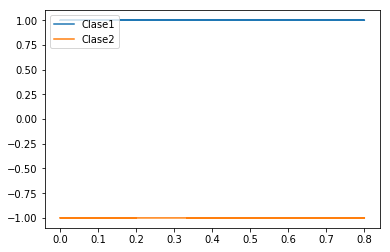

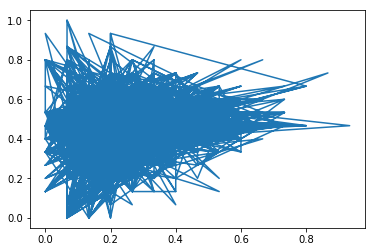

In [27]:
"""
plt.subplot(2,2,1)
plt.plot(matrix_prueba[:,0], vector_etiquetas_prueba)
plt.subplot(2,2,2)
plt.plot(matrix_prueba[:,0], prediccion_prueba)
plt.subplot(2,2,3)
plt.plot(matrix_prueba[:,0], vector_etiquetas_prueba, 'x', matrix_prueba[:,0], prediccion_prueba, 'o')

plt.plot(matrix_prueba[:,1], vector_etiquetas_prueba)
plt.show()
plt.plot(matrix_prueba[:,1], prediccion_prueba)
plt.show()
plt.plot(matrix_prueba[:,1], vector_etiquetas_prueba, 'x', matrix_prueba[:,0], prediccion_prueba, 'o')
plt.show()
"""
datos_esperadosX1_clase1 = []
datos_esperadosX1_clase2 = []
datos_esperadosX2_clase1 = []
datos_esperadosX2_clase2 = []
datos_X1_C1 = []
datos_X1_C2 = []
datos_X2_C1 = []
datos_X2_C2 = []


for k in range (len(matrix_prueba)): #len(matrix_prueba)=3000
    if(vector_etiquetas_prueba[k]==1):
        datos_esperadosX1_clase1.append(vector_etiquetas_prueba[k])
        datos_X1_C1.append(matrix_prueba[k,0])
    else:
        datos_esperadosX1_clase2.append(vector_etiquetas_prueba[k])
        datos_X1_C2.append(matrix_prueba[k,0])
        
for k in range (len(matrix_prueba)): #len(matrix_prueba)=3000
    if(vector_etiquetas_prueba[k]==1):
        datos_esperadosX2_clase1.append(vector_etiquetas_prueba[k])
        datos_X2_C1.append(matrix_prueba[k,1])
    else:
        datos_esperadosX2_clase2.append(vector_etiquetas_prueba[k])
        datos_X2_C2.append(matrix_prueba[k,1])

vector_datos_esperadosX1_clase1 = np.array(datos_esperadosX1_clase1)
vector_datos_esperadosX1_clase2 = np.array(datos_esperadosX1_clase2)
vector_datos_entradaX1_clase1 = np.array(datos_X1_C1)
vector_datos_entradaX1_clase2 = np.array(datos_X1_C2)
vector_datos_esperadosX2_clase1 = np.array(datos_esperadosX2_clase1)
vector_datos_esperadosX2_clase2 = np.array(datos_esperadosX2_clase2)
vector_datos_entradaX2_clase1 = np.array(datos_X2_C1)
vector_datos_entradaX2_clase2 = np.array(datos_X2_C2)
print("Dimensiones vector de datos esperados clase 1 en la prueba: ", np.shape(vector_datos_esperadosX1_clase1)) #(1257,)
print("Dimensiones vector de datos esperados clase 2 en la prueba: ", np.shape(vector_datos_esperadosX1_clase2)) #(1743,)
print("Dimensiones matrix de prueba: ", np.shape(matrix_prueba)) #(3000,16)

plt.figure(1)   # Activando el gráfico 1
plt.plot(vector_datos_entradaX1_clase1, datos_esperadosX1_clase1, label = "Clase1")
plt.plot(vector_datos_entradaX1_clase2, datos_esperadosX1_clase2, label = "Clase2")
plt.legend(loc="upper left")

plt.figure(2)
plt.plot(matrix_prueba[:,4], matrix_prueba[:,5])